In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve, plot_roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import svm



plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this chapter we will **only talk about classification**. Classifiers associate a transformed set of features to one of two class (a discrete variable): 0 or 1. Even when doing multiclass classification you often go back (thanks to some algo) to a problem of two classes: 0 or 1.

![class_reg](../images/class_reg.png)

In this notebook we are going to focus on distance based classification method (opposed to decision tree for example wich works with threshold more than actual distances). The goal is to give you some insight on 4 different levels:
- **Best practice** 
- **Intuition on the concepts behind those methods**
- **How to implement them with Scikitlearn**
- **Intuition on the different parameters that your model need but are not trainable (hyperparameters)**

# Distance based classification method
## Table Of Content: <a id='toc'></a>

* [Meet the data](#data)
    * [Multiclass dataset : penguins identification](#data-penguin)
    * [Binary class dataset : breast cancer](#data-cancer)

* [Feature selection](#second-bullet)
    * [Exercise - feature selection](#exo-feature)

* [**K-nearest neighbors : introduction to basic routine in ML**](#neighbors)
    * [Toy dataset: KNN concepts and hyperparameters](#KN-concepts)
    * [Cancer dataset/introduction to metrics and ML concepts](#K-cancer)
        * [splitting the dataset : train and test sets](#split)
        * [a metric to score classification : accuracy](#accuracy)
        * [Hyper-parameters](#hyperparam)
    * [Exercise KNN](#MC-KN)
    
    
* [**Logistic regression and the ooportunity to use AUC ROC**](#Logistic-regression)
    * [Concepts: what is linear regression and introduction to regularization](#Logistic-regression)
    * [Toy dataset: introdution to the AUC ROC](#AUC-ROC)
        * [imbalanced dataset](#Unbalanced)    
    * [Breast cancer dataset](#LR-hyper)
    * [Exercise : optimize an LR classifier hyper-parameters](#LR-cancerexo)
    * [LR with Multiclass](#MR-LR)
        * [LR on the penguin dataset](#LR-PENGUIN)
    
    
* [**Support Vector Machine**](#SVM)
    * [Concepts](#SVM)
    * [Toy dataset with linear kernel](#SVM-linear)
    * [Toy dataset with nonlinear kernel](#SVM-nonlinear)
    * [Cancer dataset: playing with the hyperparameters](#SVM-hyperparameters)
    
    
* [**Exercise**](#exo)

* [Appendix : Precision-Recall curves and alternative metrics](#PRcurve)


# Meet the data <a id='data'></a>

During this chapter we will play with two dataset and alternate demonstration and exercises on both.

[Back to the ToC](#toc)

## Multiclass dataset : penguins identification <a id='data-penguin'></a>

This dataset consists in data from 344 penguins grouped in three species :

![penguins](../images/lter_penguins.png)
*Artwork by @allison_horst*

[dataset source](https://allisonhorst.github.io/palmerpenguins/)


Among the columns present in there, we drop the ones, like `StudyID` or `sampleNumber` to keep only columns of potential interest for the task at hand :

In [4]:
df_penguin = pd.read_csv( "../data/horst2020_palmerpenguins_raw.csv" )

kept_columns = [ 'Species',  'Island', 'Clutch Completion', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


## keep the nice doodle color code!
penguin_colors = {'Adelie':'#FF8C00',
                  'Chinstrap':"#A020F0",
                  'Gentoo':"#008B8B"}


df_penguin = df_penguin.loc[: , kept_columns ]
# keep only the first word of the species field. We do not need the latin name here
df_penguin.Species = df_penguin.Species.apply(lambda x: x.partition(' ')[0])
df_penguin.head()

Species     Island Clutch Completion  Culmen Length (mm)  Culmen Depth (mm)  \
0  Adelie  Torgersen               Yes                39.1               18.7   
1  Adelie  Torgersen               Yes                39.5               17.4   
2  Adelie  Torgersen               Yes                40.3               18.0   
3  Adelie  Torgersen               Yes                 NaN                NaN   
4  Adelie  Torgersen               Yes                36.7               19.3   

   Flipper Length (mm)  Body Mass (g)     Sex  Delta 15 N (o/oo)  \
0                181.0         3750.0    MALE                NaN   
1                186.0         3800.0  FEMALE            8.94956   
2                195.0         3250.0  FEMALE            8.36821   
3                  NaN            NaN     NaN                NaN   
4                193.0         3450.0  FEMALE            8.76651   

   Delta 13 C (o/oo)  
0                NaN  
1          -24.69454  
2          -25.33302  
3                NaN  
4          -25.32426

The columns correspond to :

* **Species** : the penguin species
* **Island** : the island near Palmer Station where samples were collected
* **Clutch Completion** : if the study nest ws observed with a full clutch, i.e., 2 eggs
* **Culmen Length** : length of the dorsal ridge of a bird's bill (millimeters)
* **Culmen Depth** : the depth of the dorsal ridge of a bird's bill (millimeters)
* **Flipper Length** : the length of a bird's flipper (millimeters)
* **Body Mass** : the penguin body mass (grams)
* **Sex** : the sex of the animal
* **Delta 15 N** : measure of the ratio of stable isotopes 15N:14N
* **Delta 13 C** : measure of the ratio of stable isotopes 13C:12C

You can see there are some NAs. Let's throw away samples with Nas (only 20 of them):

In [5]:
K = df_penguin.isnull().sum(axis=1) < 1

df_penguin = df_penguin.loc[K,:]
df_penguin.shape

(324, 10)

In [6]:
df_penguin.Species.value_counts()

Adelie       139
Gentoo       118
Chinstrap     67
Name: Species, dtype: int64

In [7]:
## finally, we separate the target variable (Species) from the rest
y_penguin = df_penguin.Species

# here note the usage of pd.get_dummies to one-hot encore categorical data!
X_penguin = pd.get_dummies(df_penguin.drop( columns="Species" ), drop_first=True)

[Back to the ToC](#toc)

## Binary class dataset : breast cancer <a id="data-cancer"></a>

This time, no cute doodle, but maybe that is for the best.

In the cancer dataset you have 569 tumors for which many features have been measured. The goal is to predict if the tumor is malignant or not.

In [8]:
# the breast cancer dataset is integrated in the sklearn library
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)


# for some reason this dataset has encoded 0 for malignant,
# which is extremely counter intuitive
# So I choose to switch it to the more intuitive order now
y_cancer  = 1 - y_cancer 
df_cancer.malignant = 1-df_cancer.malignant

# 0 : benign
# 1 : malignant


df_cancer.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  malignant  
0          0.4601                  0.11890          1  
1          0.2750                  0.08902          1  
2          0.3613                  0.08758          1  
3          0.6638                  0.17300          1  
4          0.2364                  0.07678          1  

[5 rows x 31 columns]

In [9]:
print('features:\n')
for s in df_cancer.columns:
    print(s)

features:

mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
mean fractal dimension
radius error
texture error
perimeter error
area error
smoothness error
compactness error
concavity error
concave points error
symmetry error
fractal dimension error
worst radius
worst texture
worst perimeter
worst area
worst smoothness
worst compactness
worst concavity
worst concave points
worst symmetry
worst fractal dimension
malignant


In [10]:
df_cancer.malignant.value_counts()

0    357
1    212
Name: malignant, dtype: int64

So, there is a slight over-representation of benign tumors.

[Back to the ToC](#toc)

# Feature selection <a class="anchor" id="second-bullet"></a>

Feature selection serves two main purposes :

* reducing the computational cost of your model building and hypter-parameter exploration
* (sometimes) improve your model accuracy


A first good approach can be to look at your features correlations :

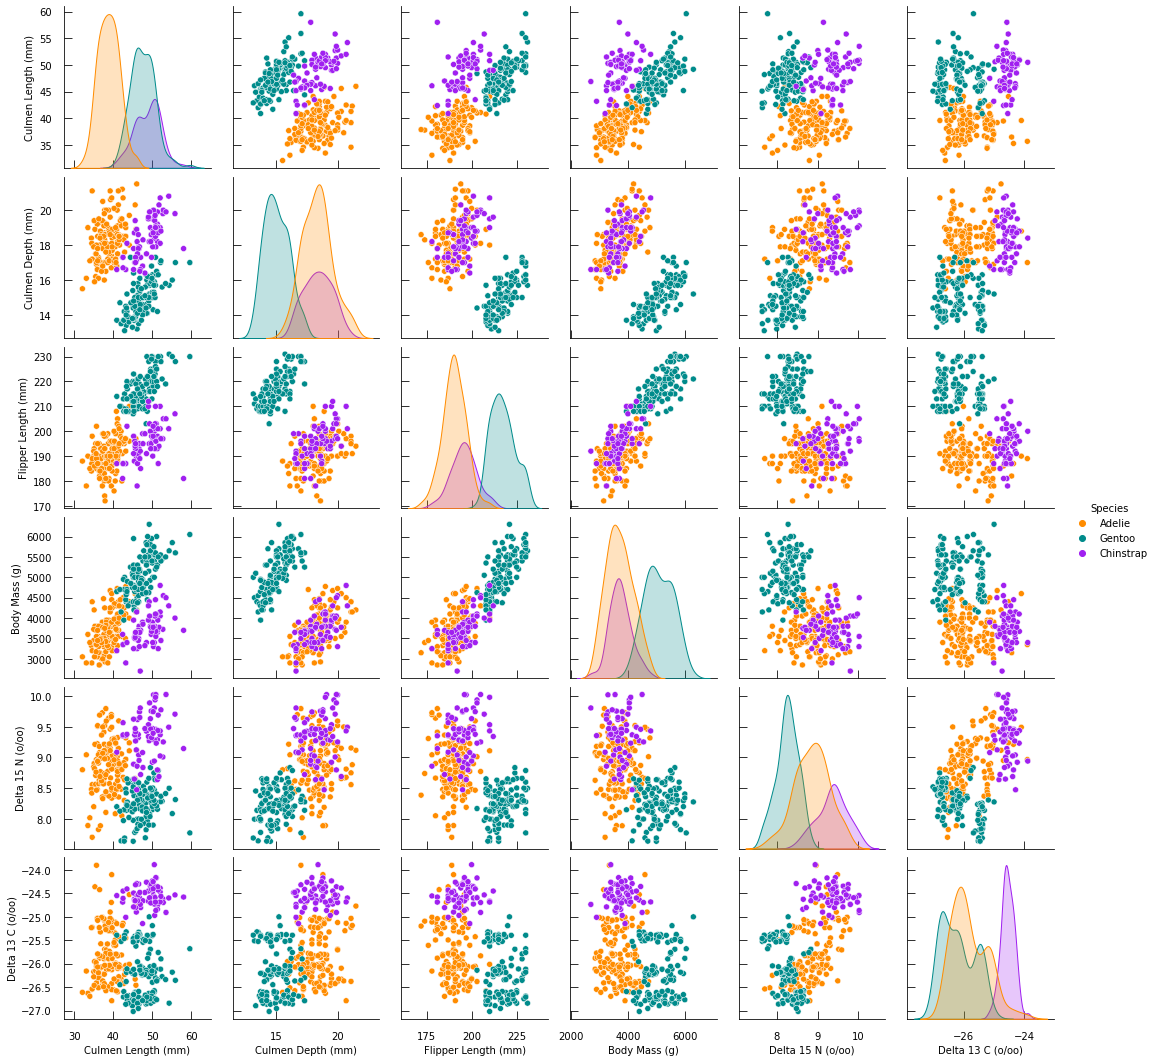

In [11]:
sns.pairplot(df_penguin , hue = "Species", palette=penguin_colors)

In [12]:
T1 = pd.crosstab( df_penguin.Species , df_penguin.Island )
T2 = pd.crosstab( df_penguin.Species , df_penguin.Sex )
T3 = pd.crosstab( df_penguin.Species , df_penguin["Clutch Completion"] )
pd.concat([T1,T2,T3], axis=1)

Biscoe  Dream  Torgersen  FEMALE  MALE  No  Yes
Species                                                   
Adelie         44     52         43      71    68  13  126
Chinstrap       0     67          0      34    33  14   53
Gentoo        118      0          0      58    60   7  111

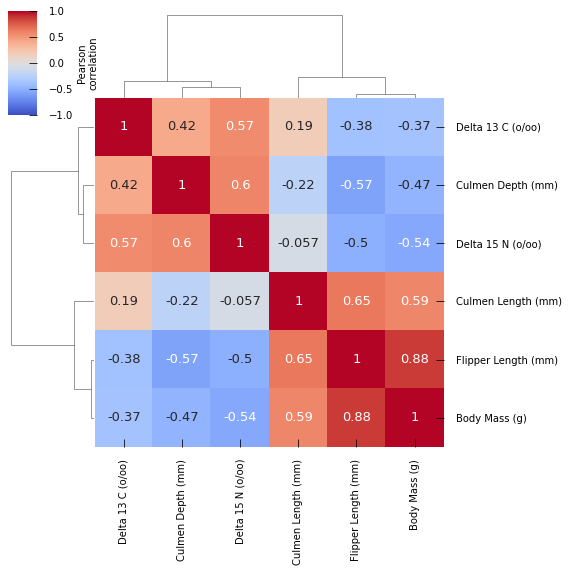

In [13]:
df_penguin_corr = df_penguin.corr()

sns.clustermap(df_penguin_corr,
               figsize=(8,8),
               z_score=None,
               row_cluster=True,
               col_cluster=True,
               method='ward',
               cmap='coolwarm',vmax=1,vmin=-1, 
               annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})
## sns allows you to do a hierarchical clustering that simply
plt.show()

The above pearson correlation matrix is highly informational. 

It allows you to see that **some variables are probably redundant** and so you don't need to have all of them, hence reducing the complexity of your model. 

Moreover it is usually bad to have highly correlated variables in your model since it is making unstable and less interpretable. 

ML algorithms are less sensible to that (decision tree are quite good at dealing with co-variable correlation) but for approaches like logistic regression and regression in general it can be a bit more problematic. 

Here, some variables are heavily correlated, for instance flipper length and body mass, but not too a point where we would drop them right away.


One thing (among others) that you can do is to look for a **subset of features that seems to be important to describe the target class**. It's like the pairplots above but instead of just looking at it you choose the features you want to keep.

You can choose different metrics for *"how important to describe the class"* a feature is. 

Many of those metrics rely on concepts that we haven't introduced yet, in contexts that we haven't seen yet, so I will only introduce a couple of metrics for classification that don't need too much of *a priori* knowledge. 

* **ANOVA-F** : F=$\frac{Var_{feature\_i}(Between\_class)}{Var_{feature\_i}(Within\_class)}$. 

> **F** : how much a feature $i$ variance is different between classes, normalized by the intrinsic variance of that feature per class. 
>
> So if **F** is big it means that the variation that you observe between classes is big compared to the variance of this feature : it behaves differently for different classes then it is a good feature to keep for the classification. 
>
> To this **F** is associated a **p-value** that you would use for scoring.


* **Chi2** ($\chi^{2}$) test. 

> You suppose the null hypothesis that feature $i$ is homogenously distributed among classes and so you are expecting that its representation in different classes should be very similar to what you can calculate for the bulk data
> i.e. $\frac{\Sigma^{n\_points} feature_{i}}{n\_points}$.
>
> You then compare the actual distribution of this feature in different classes to your null model predictions. If this **sum of square differences**: 
>
> $\Sigma^{n\_class}_{k}\frac{(expected\_form\_null\_hypothesis_{k}-observed_{k})^{2}}{observed}$
>
> is big then the null hypothesis has to be rejected and this feature is significant for classifying. 
>
> The sum of these square quantities over the different classes asymptotically follows a $\chi^{2}$ 
> distribution and thus you have access to a **p-value for scoring**.


* Another score would be to use the amount of [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) shared between a feature and our target. The way this mutual information is caclulated is out of the scope of this class as it is a bit technical.


Once you have a metric for feature importance, `Scikit-learn` lets you specify a threshold on the features that are kept, either as:
* a direct number: `SelectKBest`.
* important features from a percentile of your top importance score: `SelectPercentile`.
* an error type: `SelectFpr` or `SelectFdr` (we will introduce the FPR and FDR later in this chapter).



In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## important note : the chi2 test requires your data to be non-negative. 
## Here we will ensure column 'Delta 13 C (o/oo)' follows this criteria :
X_penguins_tmp = X_penguin.copy()
X_penguins_tmp['Delta 13 C (o/oo)'] -= X_penguins_tmp['Delta 13 C (o/oo)'].min()


# Creating the object SelectKBest and settling for 2 best features (k=2) 
# in term of chi2 score
skb = SelectKBest(chi2, k=2)
skb.fit(
    X_penguins_tmp, 
    y_penguin)#calculating the chi2 for each features

#all the features and the chi2 pvalues associated. use .pvalues_
dico_pval={X_penguin.columns[i]:v for i,v in enumerate(skb.pvalues_)}
sortedPvals = sorted(dico_pval.items(), key=lambda x: x[1], reverse=False) 

print("features Chi2 scores (p-values):")
for feature,pval in sortedPvals:
    print('\t',feature , ':' , pval )

print("selected best:" , X_penguin.columns[ skb.get_support() ] )
    
X_new=skb.transform( X_penguin )# keep only the k=2 best features according to the score

print("New data with only the k=5 best features kept :")
print(X_new[:5,]) #printing only the 5 first entries
print('...')

features Chi2 scores (p-values):
	 Body Mass (g) : 0.0
	 Flipper Length (mm) : 2.928855193300304e-53
	 Culmen Length (mm) : 2.4523682090693275e-34
	 Island_Dream : 5.336499390772139e-26
	 Delta 13 C (o/oo) : 8.615027241190726e-20
	 Island_Torgersen : 3.7378040824253893e-13
	 Culmen Depth (mm) : 1.935417333461757e-11
	 Delta 15 N (o/oo) : 0.041021131541624865
	 Clutch Completion_Yes : 0.5756667043374695
	 Sex_MALE : 0.9748577328049562
selected best: Index(['Flipper Length (mm)', 'Body Mass (g)'], dtype='object')
New data with only the k=5 best features kept :
[[ 186. 3800.]
 [ 195. 3250.]
 [ 193. 3450.]
 [ 190. 3650.]
 [ 181. 3625.]]
...


That would reduce our dataset to :

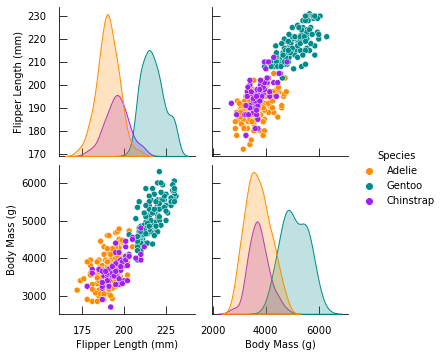

In [15]:
sns.pairplot( df_penguin , hue = "Species", palette=penguin_colors , vars = X_penguin.columns[ skb.get_support() ] )

**micro-exercise :** Does keeping these two specific feature look like a good idea for our species classification problem ? Why ?

[Back to ToC](#toc)

## Exercise - feature selection <a id="exo-feature"></a>

Look at interaction between features for the cancer datatset. What are the best features to keep to perform classification on tumor malignancy here (`y_cancer` or `df_cancer.malignant`) ?

> Use `f_classif` for the feature classification


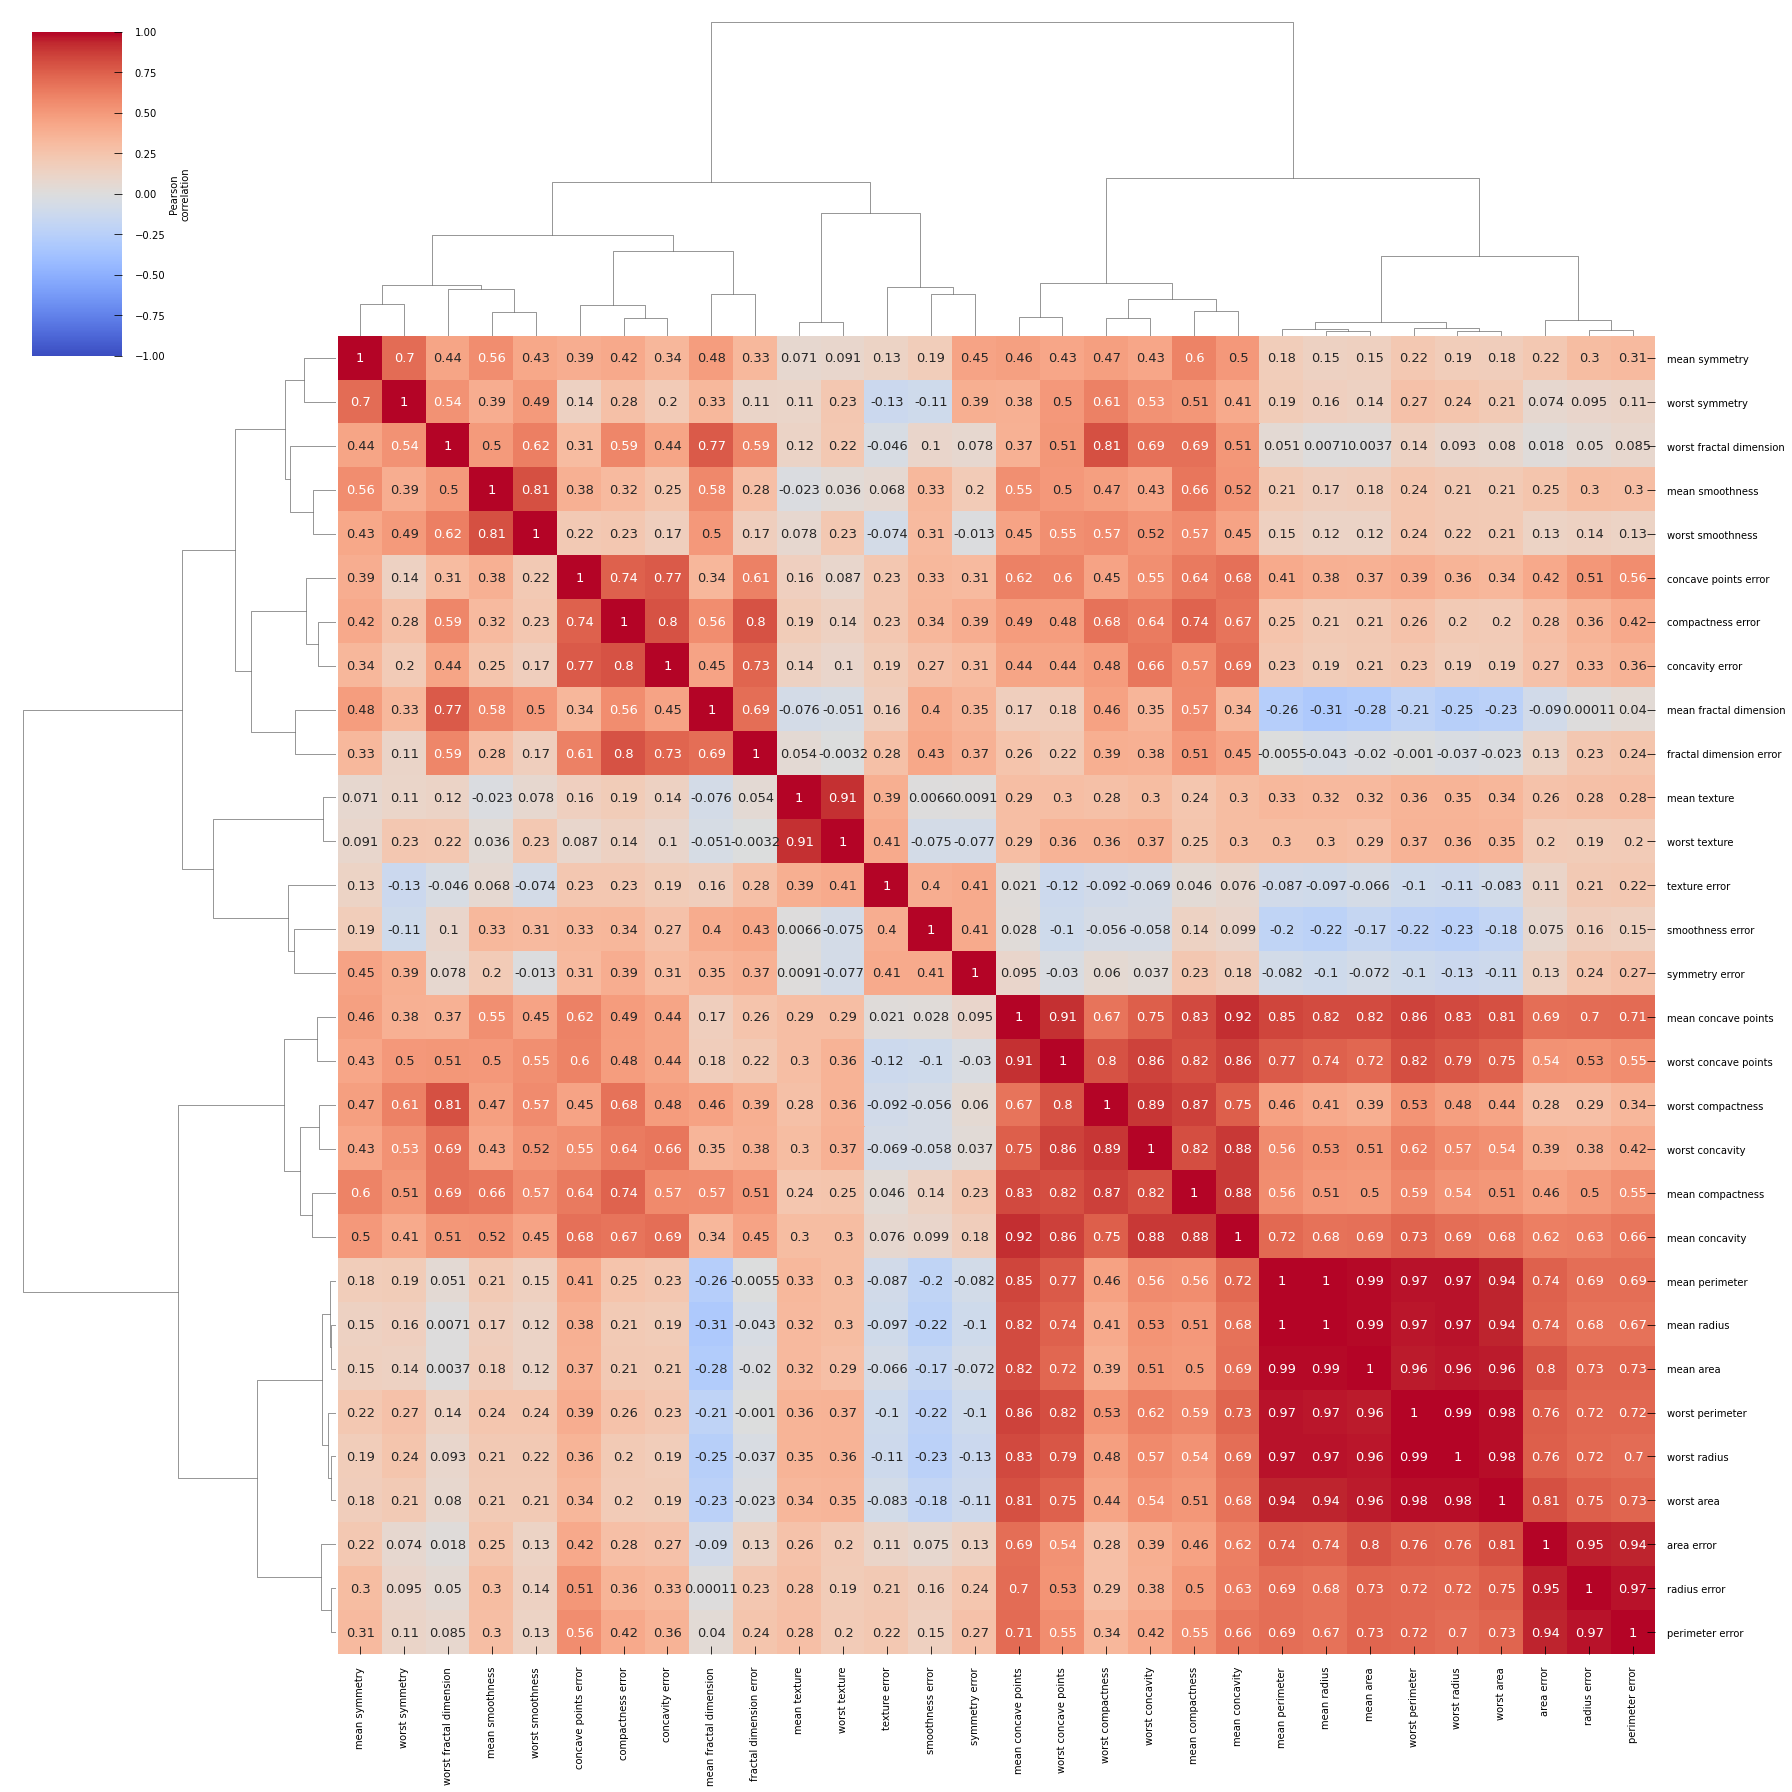

In [16]:
df_cancer_corr = df_cancer[list(df_cancer.columns)[:-1]].corr()

sns.clustermap(df_cancer_corr,figsize=(25,25),z_score=None,row_cluster=True,col_cluster=True,method='ward',cmap='coolwarm',vmax=1,vmin=-1, annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})

plt.show()

# CORRECTION NEEDS VALIDATION

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# Creating the object SelectKBest and settling for 10 best features 
skb = SelectKBest(f_classif, k=10)
skb.fit(
    X_cancer, 
    y_cancer)

#get associated pvalues
dico_pval={df_cancer.columns[i]:v for i,v in enumerate(skb.pvalues_)}
sortedPvals = sorted(dico_pval.items(), key=lambda x: x[1], reverse=False) 

print("features F scores (p-values):")
for feature,pval in sortedPvals:
    if pval > 0.01 : # let's ignore everything with a pval>0.01
        print("\t\trest has pval>0.01")
        break 
    print('\t',feature , ':' , pval )

selected10 = [x for x,p in sortedPvals[:10] ]
print("selected best:" , selected10 )

features F scores (p-values):
	 worst concave points : 1.969099707212886e-124
	 worst perimeter : 5.771397139669512e-119
	 mean concave points : 7.101150161049467e-116
	 worst radius : 8.482291921715854e-116
	 mean perimeter : 8.436251036161722e-101
	 worst area : 2.8288477042869e-97
	 mean radius : 8.465940572259249e-96
	 mean area : 4.734564310305572e-88
	 mean concavity : 9.966555755068089e-84
	 worst concavity : 2.464663956784375e-72
	 mean compactness : 3.938263105887389e-56
	 worst compactness : 7.069816352537799e-55
	 radius error : 9.738948656460721e-50
	 perimeter error : 1.6519051758490894e-47
	 area error : 5.895521392606798e-46
	 worst texture : 1.0780574879498465e-30
	 worst smoothness : 6.575143633991326e-26
	 worst symmetry : 2.9511205771550073e-25
	 mean texture : 4.058636047908563e-25
	 concave points error : 3.072308768818453e-24
	 mean smoothness : 1.051850359200222e-18
	 mean symmetry : 5.733384028468339e-16
	 worst fractal dimension : 2.3164324499884858e-15
	 compa

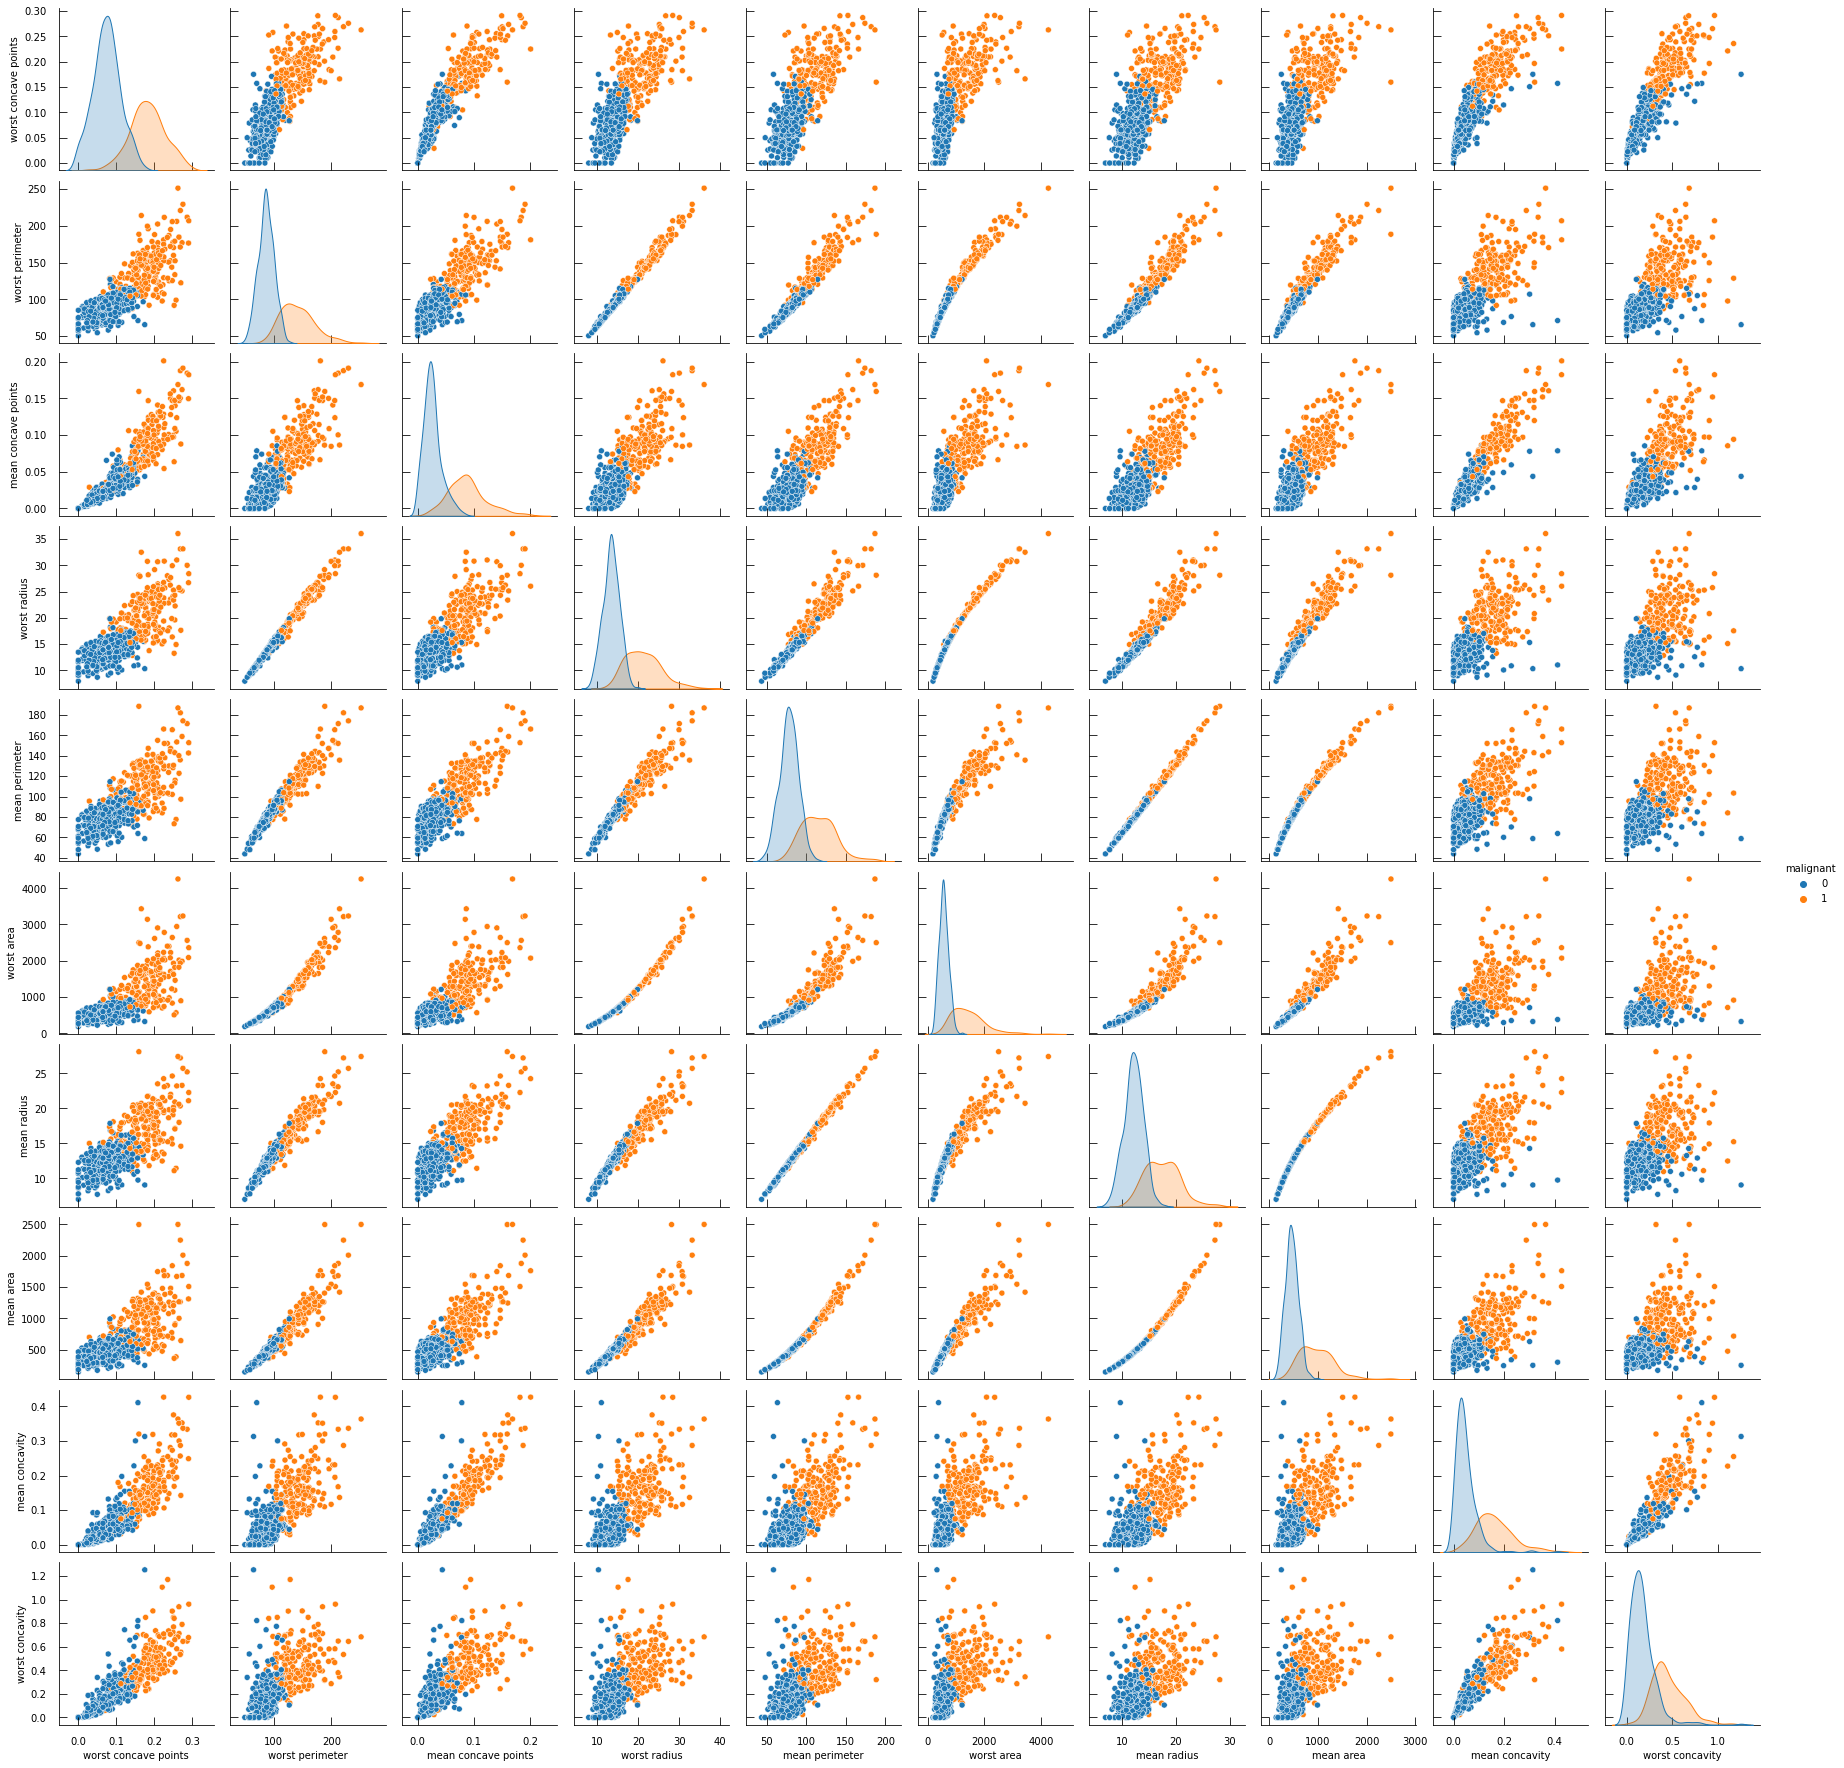

In [18]:
sns.pairplot( df_cancer , hue='malignant' , vars=selected10 )

In [19]:
## that is very nice, but a lot of these are highly correlated...
## Let's start transforming our data so we work with independent features:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc= StandardScaler()
X_cancer_norm = sc.fit_transform(X_cancer)

pca = PCA()
x_pca = pca.fit_transform(X_cancer_norm)

In [20]:
## now we can select the best feature among the principal components


skb = SelectKBest(f_classif, k=10)
skb.fit(
    x_pca, 
    y_cancer)

#all the features and the chi2 pvalues associated. use .pvalues_
dico_pval={i:v for i,v in enumerate(skb.pvalues_)}
sortedPvals = sorted(dico_pval.items(), key=lambda x: x[1], reverse=False) 

significantComponents = []

print("features Chi2 scores (p-values):")
for feature,pval in sortedPvals:
    if pval > 0.01 : # let's ignore everything with a pval>0.01
        print("\t\trest has pval>0.01")
        break 
    print('\tPC',feature , ':' , pval )
    significantComponents.append(feature)


features Chi2 scores (p-values):
	PC 0 : 2.9337868112211856e-120
	PC 1 : 6.073144517814298e-06
	PC 2 : 7.846658265552653e-05
	PC 3 : 0.0022984052580383137
		rest has pval>0.01


selected components explained variance fractions:
	 [0.44272026 0.18971182 0.09393163 0.06602135]
Total :	 0.7923850582446096


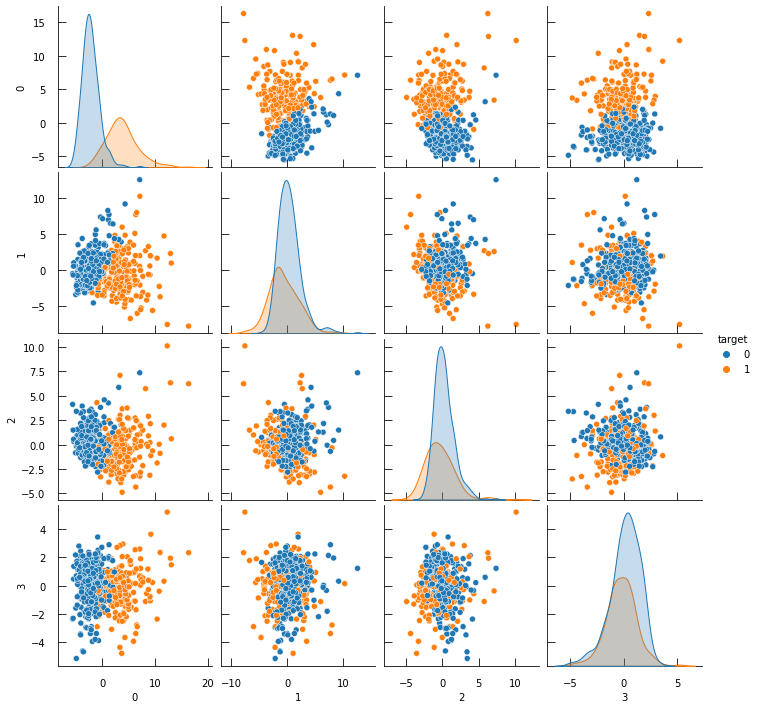

In [21]:
## Wow, they actually correspond to the elements with the highest variance ratio representation!
print( "selected components explained variance fractions:\n\t",pca.explained_variance_ratio_[ significantComponents ] )

print( "Total :\t",sum(pca.explained_variance_ratio_[ significantComponents ]) )

df_pca = pd.DataFrame( x_pca[:, significantComponents ] )
df_pca['target'] = y_cancer

sns.pairplot( df_pca , hue="target" )

[Back to ToC](#toc)

# K-nearest neighbors +  some basic routine <a class="anchor" id="neighbors"></a>

K-nearest neighbors is a pretty simple algorithm in terms of concept but it already has few hyperparameters that you should  understand and try to optimize. It will introduce you to some of the very experimental like routine that machine learning is.

For a classifier, k-nearest neighbors works as follow. 

**First the algorithm simply saves the labels that it is given during the training phase**. 

Then during the testing phase it takes a testing point and checks its `n_neighbors` nearest neighbors. 

**If `n_neighbors` nearest neighbors are mostly (in majority) from one label then the tested point will be assigned this label**. 

The way the `n_neighbors` **nearest neighbors vote** can be either 

 * uniform (every point as the same importance in the vote) or,
 * distance-based (a point distant to the tested point by a distance d will have a weight of 1/d in the vote).

![knn](../images/knn.png)

[Image from datacamp tutorials](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)

[Back to the ToC](#toc)

### Toy dataset: KNN concepts and hyperparameters<a class="anchor" id="KN-concepts"></a>

In [22]:
#Let's make some toy dataset. Here using the sklearn function making blobs for you!!!

from sklearn.datasets import make_blobs

# 120 points, 3 blobs/clusters with some spread=3
X_3, y_3 = make_blobs(n_samples=120, 
                      centers=3,
                      cluster_std=[[1,3],[1,3],[1,3]], random_state=6)

#Random_state is here just to be sure that every time you will get the same blobs. 
# If you change the random_state or do not
# specify it then you will get a new plot every time you call the function (random seed)

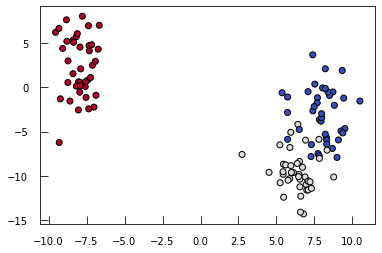

In [23]:
plt.scatter(X_3[:,0],X_3[:,1],c=y_3,cmap=plt.cm.coolwarm,edgecolors='k')
plt.show()

In [24]:
## install pydotplus if that is not already done
!pip install pydotplus

<AxesSubplot:title={'center':'K neighbors k=1, uniform'}>

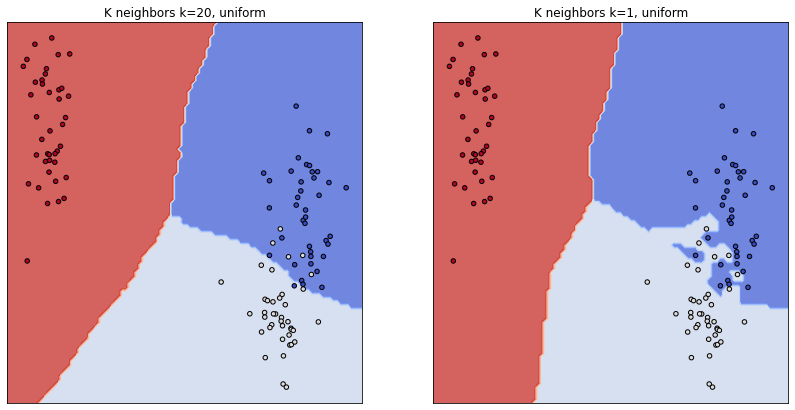

In [25]:
from utils import countour_knn
fig,axes = plt.subplots(1,2,figsize=(14,7))

## 20 neighbors
countour_knn(20,X_3,y_3,'uniform', ax=axes[0])

## 1 neighbors
countour_knn(1,X_3,y_3,'uniform', ax=axes[1])

In the above we varied the number of voters (neighbors) to decide weither a point is from one class or another. You can see how the **boundaries are way more wiggly and attentive to missclassification when the number of neighbors is low**. But you can also imagine that if **new data is added those kind of too specific boundaries are going to missclaissify the new points. This is a first example of this bias variance trade off.**

<AxesSubplot:title={'center':'K neighbors k=1, distance'}>

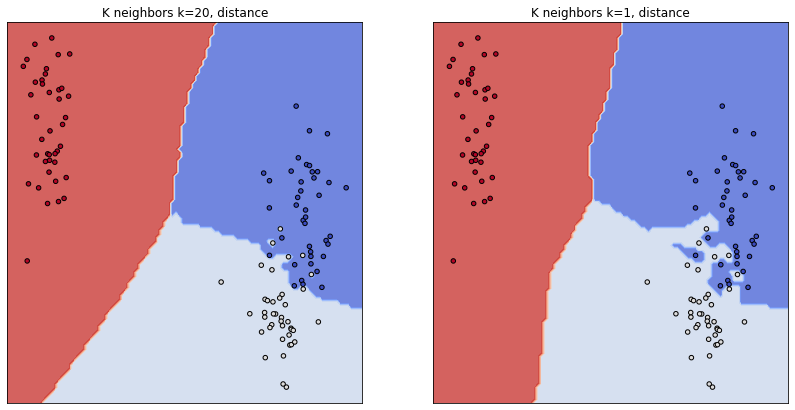

In [26]:
fig,axes = plt.subplots(1,2,figsize=(14,7))

countour_knn(20,X_3,y_3,'distance', ax=axes[0])
countour_knn(1,X_3,y_3,'distance', ax=axes[1])

Another parameter is how voting is done. Of course for only 1 neighbors this is the same graph as before. But for 20 neighbors you can see isle of white point in bleu territory : again overfitting.

[Back to the ToC](#toc)

## Cancer dataset/introduction to metrics and ML concepts <a class="anchor" id="K-cancer"></a>

### splitting the dataset : train and test sets <a class="anchor" id="split"></a>

**We will have to divide our data set into a train and a test set**. 

![train_test](../images/train_test.png)


The **test set should never be touched until the last step which is the model evaluation**. By doing so we can be confident that our measure of generalization efficiency of our model is as correct as it can be. 

We say that no information coming from the test set should leak into the train set. If this is the case, we are biasing our understanding of the generalizability of our model. 
To avoid **leakage** you should ensure your test set is absent from even the early stages of your pipeline, such as imputation or feature selection (so you have guessed it, most of the operations we have done until now have lead to leakage...).

I would like to give you some examples on how leakage can spoil your models but I will need to use many tools that we haven't touched yet. So for now believe me on the necessity to split your dataset. Maybe later when you will have all those tools try to persuade yourself.

In [27]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, 
                                                                                y_cancer,
                                                   random_state=7,stratify=y_cancer) 

# train_test_split make sure to split the data such 
# that the two partitions ressemble each other statistically speaking
# For example a bad splitting would be that your training set have 
# 99% of one label and your testing set 99% of the other....

## Let's create a simple KNN classifier:
Kneighbors = KNeighborsClassifier(n_neighbors = 5, weights='uniform',n_jobs=-1)
Kneighbors.fit(X_cancer_train, y_cancer_train)

# the .score() function takes data and the correct label and give a "score"
score_train = Kneighbors.score(X_cancer_train,y_cancer_train)
score_test = Kneighbors.score(X_cancer_test,y_cancer_test)

print('Acc= {0:.3f} on train, Acc= {1:.3f} on test'.format(score_train,\
                                                           score_test))

Acc= 0.948 on train, Acc= 0.937 on test


So far I haven't defined a way to measure the quality of our classifier. Spoiler alert it is what is above called Acc for **Accuracy**. I will define what it is so bear with me. For now we have a more important problem:

In the previous example we didn't rescale the data! **It can be really important to rescale your data mainly when the method you are using are based on distances (scalar product) or similarity** (remember the PCA, where we discussed this phenomenon). 

As the K-neighbors method is distance-based, and our various columns operate on different scale, we will rescale our data:

In [28]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler() 
scaler.fit(X_cancer_train)
# the scaler is fit only on the train data!!!!!!!! 
# Doing it on the full data set is a perfect case of
# data leakage : you are going to provide a mean and a standard deviation 
# calculated with data containing the test set and 
# that's enough to bias your understanding of the model.

# Thus, you should always rescale data AFTER the splitting
X_cancer_train_scaled = scaler.transform(X_cancer_train)

# Now we scale the test set with the scaler fitted on the train set only
X_cancer_test_scaled = scaler.transform(X_cancer_test)


Kneighbors_scaled = KNeighborsClassifier(n_neighbors = 5, weights='uniform',n_jobs=-1)
Kneighbors_scaled.fit(X_cancer_train_scaled, y_cancer_train)

# computing our scores 
score_train = Kneighbors_scaled.score(X_cancer_train_scaled,y_cancer_train)
score_test = Kneighbors_scaled.score(X_cancer_test_scaled,y_cancer_test)

print('Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(score_train,\
                                                           score_test))


Acc= 0.979 on scaled train, Acc= 0.965 on scaled test


You can see that now that we have performed scaling our accuracy has improved: from 0.944 to 0.972 on the test set. That is nice, but what is accuracy and how should we interpret it ?



> Note : Here we have done this for pedagogical purpose, but note that using an improvement in test set accuracy to decide between using scaled data or not is a form a leakage as well! Yes, leakage is a perfidious thing.

[Back to the ToC](#toc)


### a metric to score classification : accuracy <a id="accuracy" ></a>

One straight forward metric to evaluate our method is the accuracy. Accuracy is only interesting on the test set, eventhough it can give you some good insight about your model when accuracy is compared between test and training set. 

But again, the main thing that is going to matter to evaluate your model concern metric evaluated on the test set.


Accuracy is defined as follow : $\frac{TP+TN}{P+N}$

* TP : True Positive
* TN : True Negative
* FP : False Positive
* FN : False Negative
* P : Positive : $P=TP+FN$
* N : Negative : $N=TN+FP$


[Back to the ToC](#toc)

### Hyper-parameters <a id="hyperparam"></a>

#### Partition size

let's continue working on the cancer dataset

As introduced before we split data into a training set and a test dataset. Let's see how the **partition size** can affect our model learning.

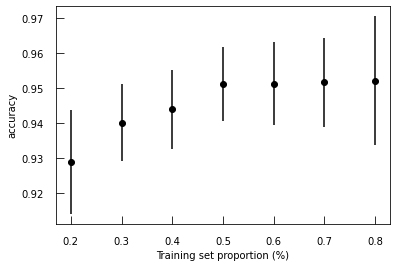

In [29]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform',n_jobs=-1)

plt.figure()

for s in t:

    ## for each partition size 
    # we will split the dataset randomly 100 times to assess the effect
    scores = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_cancer, 
                                                            y_cancer, 
                                                            test_size = 1-s, 
                                                            stratify=y_cancer)
        scaler = StandardScaler() 
        scaler.fit(X_train) 

        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        knn.fit(X_train_scaled, y_train)
        scores.append(knn.score(X_test_scaled, y_test))
    plt.errorbar(s, np.mean(scores),yerr=np.std(scores),c='k',marker='o')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

Of course if your training dataset is too small it is not going to be representative of the whole dataset and your accuracy on the test set is going to be small. 

The bigger the training set proportion, the better the chance of recapitulating the whole dataset. However this proportion should not be too big either because you still want a significant part of your dataset to be unseen for evaluating your model.

#### number of neighbors

Let's see how the number of neighbors actually influence the accuracy of our model. So far we just put some random values for this parameter. First with the `'uniform'` voting weights:

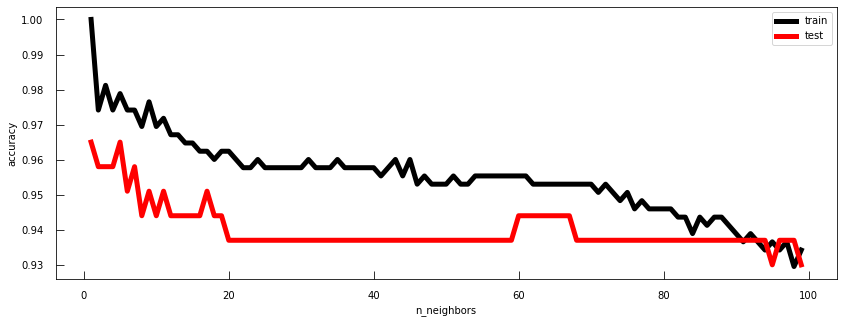

In [30]:
k_range = range(1,100)
scores_test = []
scores_train = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform',n_jobs=-1)
    knn.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(knn.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(knn.score(X_cancer_train_scaled, y_cancer_train))

plt.figure(figsize=(14,5))
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

The train set accuracy decreases with the number of neighbors involved in the vote. For very small values of `n` we are clearly overfitting : accuracy at 1 for the training set and a big drop in the accuracy of the test set.

But, using this sort of curve to decide on a reasonable value for the number of neighbors  is leakage again : the test set is informing our decision with respect to our models...

We need a method to be able to evaluate our model, in particular avoid overfitting, that does not rely on the test set.

#### Exploring and choosing in the hyperparameter space : ML routine

**If your dataset is big enough you should subdivise your training set into a true training set and what is called a validation set**. You are going to explore the hyperparameters space and optimize those hyperparameters only using the remaining training test and evaluate the choice of hyperparameters on the validation set.


![pres3](../images/Presentation3.png)

If you can't afford to split again your training set, you can use **Cross-Validation.**

Scikit-learn provides a nice built in way to vary hyperparameters and pick the best ones, through the **`GridSearchCV` method** (among others).

The CV in `GridSearchCV` refers to Cross-Validation : it means that the training data is split in N (typically 5) parts. between a training and validation set. 

For a specific set of hyperparameter values, we fit as many models as there are parts :
the model is trained on N-1 parts and evaluated on the remaining one.

The average score (e.g. accuracy) from those multiple fitting correspond to the score of this particular set of parameters.

`GridSearchCV` evaluates all possible combination of hyperparameters values it is given, and take the one giving the best score.

But an image is worth a thousand words :

![pres4](../images/Presentation4.png)

Just like before when we were splitting data between test and training, we have to be careful that we don't have **data leakage between the training and validation sets**. This is why the scaling should be done on the specific subset of training for every five folds. 

**To do so we will have to create a pipeline : which is a scikit way to automatize tasks.**

In [31]:
from sklearn.pipeline import Pipeline


knn=KNeighborsClassifier(n_jobs=-1)

# 2steps in our pipeline : scaling then KNN classification
pipeline_knn=Pipeline([('scalar',StandardScaler()),
                     ('model',knn)])

from sklearn.model_selection import GridSearchCV


# define the hyperparameters you want to test
# with the range over which you want it to be tested. 
grid_values = {'model__n_neighbors': np.arange(5,50,1),
               'model__weights':['uniform','distance']}
# Notice the  double underscore? It allows to refer to a specific part of
# the pipeline, here the model.

#Feed it to the GridSearchCV with the right
#score over which the decision should be made

grid_knn_acc = GridSearchCV(pipeline_knn, 
                            param_grid = grid_values, 
                            scoring='accuracy',
                            cv= 5 , 
                            n_jobs=-1)
# We do a 5-fold cross validation. Actually the default but it doesn't hurt to be explicit

grid_knn_acc.fit(X_cancer_train, y_cancer_train)

# finally, evaluate your model on the test set
y_decision_fn_scores_acc=grid_knn_acc.score(X_cancer_test,y_cancer_test)

#get the best parameters
print('Grid best parameter (max. accuracy):\n\t ', grid_knn_acc.best_params_)
#get the best score calculated from the training/validation dataset
print('Grid best score (accuracy): {:.3f}'.format( grid_knn_acc.best_score_ ) )

# get the equivalent score on the test
# dataset : again this is the important metric
print('Grid best parameter (max. accuracy) model on test: {:.3f}'.format(y_decision_fn_scores_acc) )


Grid best parameter (max. accuracy):
	  {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Grid best score (accuracy): 0.965
Grid best parameter (max. accuracy) model on test: 0.965


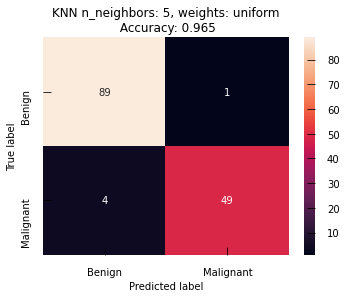

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred_test_c=grid_knn_acc.predict(X_cancer_test)

# let's define a nice function to get a confusion matrix plot

def plotConfusionMatrix( true_labels, predicted_labels, label_list , title , ax = None):

    confusion_mc_c = confusion_matrix(true_labels, predicted_labels)
    df_cm_c = pd.DataFrame( confusion_mc_c , 
                           index = label_list,
                           columns=label_list)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5.5,4))
    sns.heatmap(df_cm_c, annot=True , ax = ax)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


    
## predicting the labels on the test set    
y_pred_test_c=grid_knn_acc.predict(X_cancer_test)


plotTitle = 'KNN n_neighbors: {}, weights: {}\n Accuracy: {:.3f}'.format(grid_knn_acc.best_params_['model__n_neighbors'],
                                                                        grid_knn_acc.best_params_['model__weights'],
                                                                         accuracy_score(y_cancer_test,y_pred_test_c) )


plotConfusionMatrix( y_cancer_test, y_pred_test_c, 
                    ['Benign','Malignant'] , plotTitle , 
                    ax = None)
    


**Congrats!!!! You just trained a classical machine learning model using best practice in term of scaling, hyperparameter choice, and data leakage.**

You just followed the routine that will be our in this whole course.

![pres2](../images/Presentation2.png)

Now you might want to save your beautifull model so you can use it latter on , with new unknown data. For that you will need to.

Retrain your model on the full training set using the grid_knn_acc.best_params_ best hyperparamters found. 

Then **save your trained model using pickle**.


```python
import pickle
pickle.dump(model, open(filename, 'wb'))
```

**if you want to load it again**
```python
loaded_model = pickle.load(open(filename, 'rb'))
```

[Back to ToC](#toc)

##  Exercise KNN <a class="anchor" id="MC-KN"></a>

Tune (ie. find the best hypterparameters and train) a KNN model for classifying penguin species.

In [33]:
X_penguin.head()

Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  \
1                39.5               17.4                186.0         3800.0   
2                40.3               18.0                195.0         3250.0   
4                36.7               19.3                193.0         3450.0   
5                39.3               20.6                190.0         3650.0   
6                38.9               17.8                181.0         3625.0   

   Delta 15 N (o/oo)  Delta 13 C (o/oo)  Island_Dream  Island_Torgersen  \
1            8.94956          -24.69454             0                 1   
2            8.36821          -25.33302             0                 1   
4            8.76651          -25.32426             0                 1   
5            8.66496          -25.29805             0                 1   
6            9.18718          -25.21799             0                 1   

   Clutch Completion_Yes  Sex_MALE  
1                      1         0  
2                      1         0  
4                      1         0  
5                      1         1  
6                      0         0

In [34]:
y_penguin.value_counts()

Adelie       139
Gentoo       118
Chinstrap     67
Name: Species, dtype: int64

In [35]:
# %load -r 1-7 solutions/solution_02_KNN.py
## train-test separation

In [36]:
# %load -r 7-26 solutions/solution_02_KNN.py
## pipeline building and training

In [37]:
# %load -r 27-34 solutions/solution_02_KNN.py
## best model report

In [38]:
# %load -r 35- solutions/solution_02_KNN.py
## confusion matrix

[Back to the ToC](#toc)

# Logistic Regression <a class="anchor" id="Logistic-regression"></a>

**The main hypothesis of logistic regression is that the log odds ratio of the probability that a point is part of a certain class follows a linear combination of the features describing this point.**

Let's say you only have two classes and so your target variable can only take two values $\textbf{Y\{1,0\}}$. Let's define p=P(Y=1) the probability than your datapoint belongs to class 1. Let's also say that you have $n$ features to describe a point $\{x_{i}\}_{i=1,n}$. And that you have $m$ points.

Then we make the hypothesis that:

$ln{\frac{p}{1-p}}=w_{0}+\Sigma^{n}_{i=1}w_{i}x_{i}$

which translates to

$p=\frac{1}{1+e^{-(w_{0}+\Sigma^{n}_{i=1}w_{i}x_{i})}}$

![reg](../images/lr.png)


**So the probability that your datapoint is in class 1 is the logisitic function (sigmoid) applied to the linear combination of features.** What you want is to **recover the set of $w$ that best fit your data**. 
You do that by using the maximum likelihood method (or minimizing the cross entropy : same as loglikelihood but with a negative sign in front of it)!

So, now the way we get the weights $w$ is from fitting our distribution of probability that a point is in class 1, using a **Maximum Likelihood method : we maximize the ability of our model to generate the observed (ie. training) data.** 

However by doing so we might overfit on the training set. 
To avoid that we can disturb a little the likelihood function so its maximum doesn't depend in an excessive way on the training set. 
**So we add penalty on your weights to avoid overfitting the traning set**.

Imagine there is a feature quite insignificant when it comes to predict which class your data belongs to. 
For example a feature that is present for some observation of class 1 and never present in the other classes (typically noise). 
Nevertheless your model, if not controlled for overfitting, will really try to take that feature into account because it is something that is present in one class and not in the others. 
To inflate that feature importance the model will put an overly important weight on it. 
To compensate this you can introduce a weight penalty on high weights which the maximum likelihood will only be able to compensate if this high weight dramatically improves likelihood.

Typically in our case the **regularized maximum likelihood** function that we are going to maximize is either of two (three?) forms where on the left you see the classical likelihood function and on the right the regularization term, weighted by a 1/c coefficient:

$\Sigma^{m}_{k=1}log(p_{k}) - \frac{1}{C}\Sigma^{n}_{i=1}|w_{i}|$ , l1 regularization (Lasso) C being the inverse of the weight that you put on that regularization 

$\Sigma^{m}_{k=1}log(p_{k}) - \frac{1}{C}\Sigma^{n}_{i=1}w_{i}^{2}$ , l2 regularization (Ridge) 

$\Sigma^{m}_{k=1}log(p_{k}) - \frac{1}{C}\Sigma^{n}_{i=1}(\alpha|w_{i}|+(1-\alpha)w_{i}^{2})$ , elasticnet


![reg](../images/reg.png)

For a deeper understanding of those notions :

 * [datacamp.com tutorial on regularization](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)
 * [towardsdatascience.com rugelarization page](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a)

But the rule is : when you hypothesize that you have sparse features and so you believe that among all those features **only a small subset is going to be interesting then you use l1 regularization** : it tends to put more of your features at the zero weight and so reduce the complexity of your model. 

This l1 norm that collapses non important features to zero is another way to do feature selection.

Finally unlike KNN you can interpret your model. **The bigger the absolute value of weights associated with one feature, the more important this feature is to discriminate between your classes.**


[Back to the ToC](#toc)

## Toy dataset : introduction to AUC ROC <a class="anchor" id="AUC-ROC"></a>

Let's create again a little toy dataset to demonstrate logistic regression, as well as introduce the ROC curve.

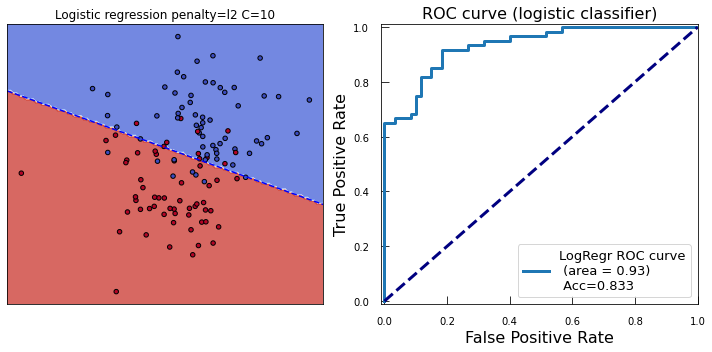

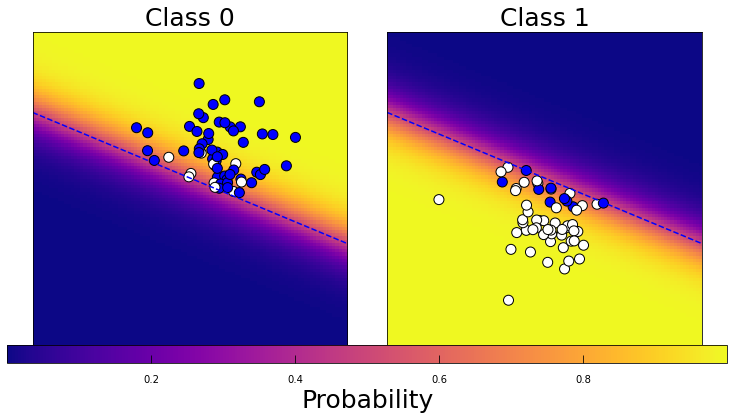

In [39]:
from utils import countour_lr
X_toy_2, y_toy_2 = make_blobs(n_samples=120, centers=2,cluster_std=3, random_state=6)

## we perform logistic regression on the toy data with
## a l2 regularization with a strength of regularization of 10
countour_lr(X = X_toy_2, 
            y = y_toy_2,
            p='l2',
            c = 10)

From how we introduced logistic regression before you can already see that an hyperplane share the same probability. What is represented in the first panel is one particular hyperplane (here a line in dimension 2) **for which the probability to be part of one of the two groups is 0.5**. 

But, actually, **0.5 is an arbitrary threshold**. The bottom panel of plots show you **many of those different hyperplanes having different probabilities and you could in principle choose any of those lines for class delimitation.**

**But why would you do that? Well for example if you want to tune how stringent you want to be towards different error types.** As before, if you deal with deciding if the patient you have in front of you should go for more exams because of a suspicion of malignant tumor, you don't want to miss any of those malignant tumors. It doesn't necessarily matter if in the process you send some clean patient for further exam. 
So maybe in that case having a 0.5 threshold for malignant tumor calling would be too stringent.

**A way to visualize those type of problem is to look at the Receiver Operating Characteristic curve (ROC). In this curve each point is a particular threshold and its coordinate are how much False positive and True positive this threshold will create.**

$FPR= \frac{FP}{FP+TN}$

$TPR= \frac{TP}{TP+FN}$

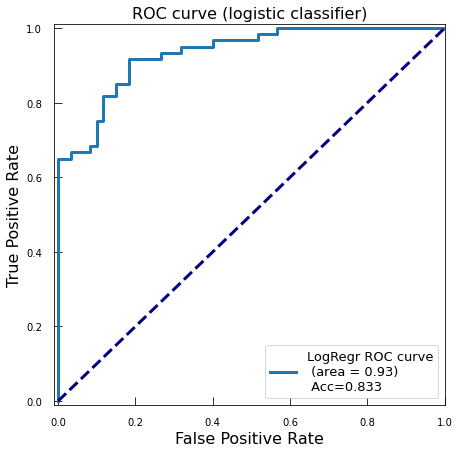

In [40]:
fig,ax=plt.subplots(figsize=(7,7))
from utils import makeROCcurve

model = LogisticRegression(penalty = 'l2',C=10, multi_class='ovr')
model = model.fit(X_toy_2,y_toy_2)
makeROCcurve(X_toy_2,y_toy_2,model, ax)

**Ideally you want a curve that perfectly follows the edge of the square** : whatever threshold you use you recover all the postive and the negative samples. So the best model should have an area under the curve of 1.  In reality the curve that you will get ressemble more the one we just got.

There is one more thing that I would like to add here, which makes this story about ROC curve and caring about the right metric even more important. **The diagonal line in the ROC curve represents what is called a dummy classifier. It is a classifier that has learned only the probabilities to have one class instead of the other. The farther you are from that line the better you are (so the more area under the curve)**. 


**micro-exercise:** On the ROC curve can you find in which direction the threshold is getting bigger?

Those comparisons to dummy classifier are really important when your dataset is **imbalanced**. 

Imagine the extreme case of a dataset made of 99 class 0 and 1 class 1. In that case your basal accuracy (the accuracy of a dummy classifier) is going to be 98% : but that doesn't make your model good. It just means that it has chosen randomly 99 point to class as 0 and 1 to class as 1. **It is a bad model even though it has a high accuracy.** 

**The ROC AUC is sensitive to imbalance**. So if you have imbalanced dataset use scoring that are sensitive to it. There are other ways to deal with it like weighting labels differently in the loss function. We will spend a little bit more time on the subject of imbalanced datasets in [Using AUC ROC to recognize artifact from unbalanced dataset](#Unbalanced), but not much. 
Just know that this problem exists and understand what it does through later on examples. Always check if your dataset is imbalanced or not and if it some classifier have built in functions to face that: logistic regression and SVC for example offer the use of the `class_weight` argument.

[back to the ToC](#toc)

### Imbalanced dataset and dummy classifier <a class="anchor" id="Unbalanced"></a>

Let's create a very **imbalanced dataset and optimize a classifier's accuracy on it** to demonstrate the issue :


In [41]:
X2_i, y2_i = make_blobs(n_samples=(500,50), centers=[[1,1],[1,1]], random_state=6)

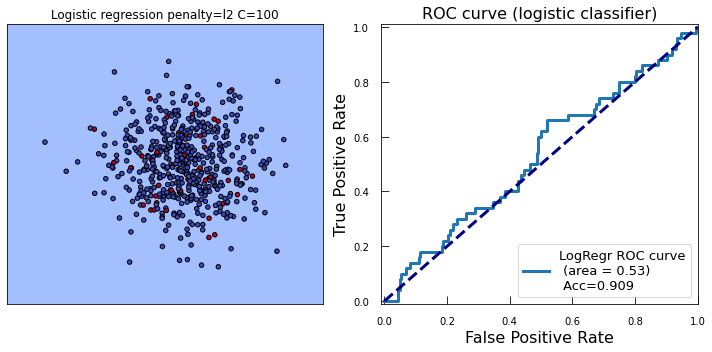

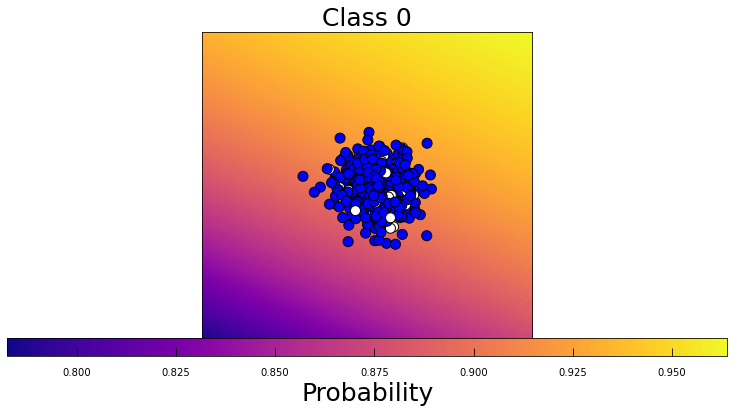

In [42]:
countour_lr(X=X2_i,y=y2_i,p='l2',c=100,mult='ovr')

**As you can see here the data was not separable from the beginning**. But just because the dataset was imbalanced (500 of one class and only 50 of the other) and we trained our model on accuracy score **we still get a good accuracy (~0.9)**. 

But this is misleading, our model is not useful right now, it is randomly assigning labels according to the statistics of the labels. Again, accuracy is informative but doesn't hold all the information.

Also, because of how this metric is built it gives the same importance in its calculation to both classes. This is why we need other metrics, such as the ROC AUC, or the precision recall curve (see the [appendix](#PRcurve))

[Back to the ToC](#toc)

## Breast cancer dataset  <a class="anchor" id="LR-hyper"></a>

Let's apply what we just saw on the breast cancer dataset and explore the LR hyper-parameters

In [43]:
#given the same importance to both classes in the log likelihood
lr = LogisticRegression(penalty='l2',C=10,class_weight='balanced')

lr.fit(X_cancer_train_scaled, y_cancer_train)

train_score = lr.score(X_cancer_train_scaled,y_cancer_train)
test_score = lr.score(X_cancer_test_scaled,y_cancer_test)

print('Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(train_score,
                                                           test_score))


Acc= 0.988 on scaled train, Acc= 0.979 on scaled test


**Effect of the strength of regularization : l2**

> Again : we have some leakage prone behavior here, for demonstration purpose. Do not do reproduce at home!

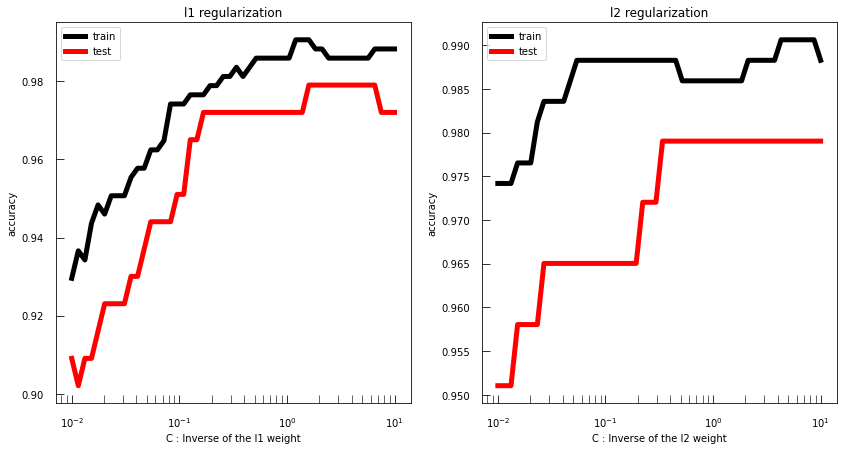

In [44]:
C_range = np.logspace(-2,1,50)

fig, ax = plt.subplots(1,2, figsize=(14,7))

for i,penaltyType in enumerate( ['l1','l2'] ):
    scores_test=[]
    scores_train=[]

    for C in C_range:
        logi_r = LogisticRegression(penalty=penaltyType, C=C,
                                    solver='liblinear',class_weight='balanced')
        logi_r.fit(X_cancer_train_scaled,y_cancer_train)

        scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
        scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))



    ax[i].plot(C_range, scores_train,'k-',linewidth=5,label='train')
    ax[i].plot(C_range, scores_test,'r-',linewidth=5,label='test')
    ax[i].set_xlabel('C : Inverse of the '+penaltyType+' weight')
    ax[i].set_ylabel('accuracy')
    ax[i].set_title(penaltyType+' regularization')
    ax[i].set_xscale('log')
    ax[i].legend(loc='best')
    

Remember : **C is inversely proportional to the strength of the regularization**.

* Too much regularization (low C) : we underfit (bad on train & test)
* Too little regularization (high C) : we overfit (good on train & bad on test)

We have to find the sweet spot...

For this we can, as before, use the `GridSearchCV` function.


[Back to the ToC](#toc)

## Exercise : optimize an LR classifier hyper-parameters <a id="LR-cancerexo" ></a>

Use `GridSearchCV` to tune a logistic regression classifier on the breast cancer dataset.

Feel free to re-use and adapt the code of the KNN pipeline. Only a few things should have changed.

The parameter space is :

```python
grid_values = {'model__C': np.logspace(-2,1,50),
               'model__penalty':['l1','l2'],
               'model__solver':['liblinear']}
```


In [45]:
# %load -r 1-21 solutions/solution_02_LR.py
## setting up and fitting the grid search cross validation

In [46]:
# %load -r 22- solutions/solution_02_LR.py
## reporting results



Let's check how the model actually discriminates the two classes with the code below. 
Or said differently : what can we learn from our model apart from pure classification.

In [47]:
from operator import itemgetter

## let's use these value. replace by your if you have seomthing different
bestC=0.256
bestP='l1'

lr = LogisticRegression(penalty=bestP,C=bestC,
                       solver='liblinear',class_weight='balanced')
lr.fit(X_cancer_train_scaled, y_cancer_train)

# we get the weights of the fitted model.
w=lr.coef_[0]

featureW = pd.DataFrame( {'feature': cancer['feature_names'],
                        'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance in discriminative process')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]


Features sorted per importance in discriminative process


feature    weight
20          worst radius  3.336841
7    mean concave points  0.998845
27  worst concave points  0.856680
21         worst texture  0.736988
24      worst smoothness  0.357166
10          radius error  0.348832
28        worst symmetry  0.338993
26       worst concavity  0.184474
1           mean texture  0.096473

threshold p=0.5
FPR 0.01 - TPR 0.94
***
threshold no FN
FPR 0.38 - TPR 1.00 - p= 0.04


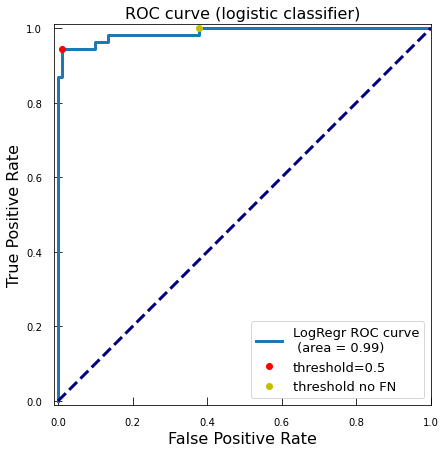

In [48]:
import scipy as sc
# the following lines here are how you get the area under the ROC curve score 
# which is very important for evaluating your model

#decision_function gives you the proba for a point to be in a class
y_score_lr_c = lr.decision_function(X_cancer_test_scaled)

# this calculates the ROC curve
fpr_lr_c, tpr_lr_c, thre = roc_curve(y_cancer_test, y_score_lr_c)

#finally this calculates the area under the curve
roc_auc_lr_c = auc(fpr_lr_c, tpr_lr_c)


## plotting the curve :

# expit is the reverse from the logit. 
# This let's us know the inferred probability at different points
proba = sc.special.expit(thre) 

## finding the point corresponding to a 0.5 proba
P05= np.argmin( np.abs( proba-0.5 ) )

print("threshold p=0.5")
print( "FPR {:.2f} - TPR {:.2f}".format(fpr_lr_c[P05], tpr_lr_c[P05]) )

## finding the point where we have no more False Negative (ie. undetected malignant cancer)
PnoFN= np.argwhere( tpr_lr_c == 1 )[0][0]
print("***")
print("threshold no FN")
print( "FPR {:.2f} - TPR {:.2f} - p= {:.2f}".format(fpr_lr_c[PnoFN], tpr_lr_c[PnoFN], proba[PnoFN]) )

## plotting
plt.figure(figsize=(7,7))
plt.axes().set_aspect('equal')

plt.plot(fpr_lr_c, tpr_lr_c, 
         lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc_lr_c))
plt.plot(fpr_lr_c[P05], tpr_lr_c[P05],
         'ro',label='threshold=0.5')
plt.plot(fpr_lr_c[PnoFN], tpr_lr_c[PnoFN],
         'yo',label='threshold no FN')
plt.plot([0, 1], [0, 1], 
         color='navy', lw=3, linestyle='--')


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.show()

From the plot above we see that putting our decision threshold to 0.5 to discriminate between cancer and non cancer lead to missing 1% of the cancer. 

**So maybe a better threshold should be a lower one that will put our red dot on the right side of the curve, optimally exactly were you have a TPR of 1.0 and a FPR around 0.38.**

[Back to the ToC](#toc)

## LR with Multiclass <a class="anchor" id="MR-LR"></a>

LR is, originally, really about classifying 0 and 1, so binary.

Of course all of that can still be applied to a multi-class classification, with a little bit of adaptation.


There are many different ways of tackling the problem, which end up being combinations of these 3 elements :

- Either you treat the problem as **one class vs one class**
- Or you treat the problem as a **one class vs the rest** : you subdivide the problem into as many problem as there are classes
- You change your loss function to a mutinomial one : **softmax intead of a sigmoid.** 

In any case you need to decide how you are going to **agglomerate those different metrics** (different ROC curves for example):

- **micro average** : pull all raw numbers together (eg. number of FP, TP), group them and then calculate your overall statistic (eg. TPR)
- **macro average** : calculate each statistics separately and then do the average.


Think about the differences induced by those metrics. Why should you use one more than the other? Or maybe you should always use all of them?

*Spoiler*: is has to do with overall separability and balance between the different class.


What strategy your logistic regression uses so you can plot the right curves, is a tricky question. For a first pass on your data always set the multiclasses method to be `ovr` (one vs rest) : understanding the hyperplanes relation to decision probability and the ROC curve is more intuitive that way, and I believe less sensitive to an imbalanced dataset.

All the ROC curve below are OnevsRest unless specified.

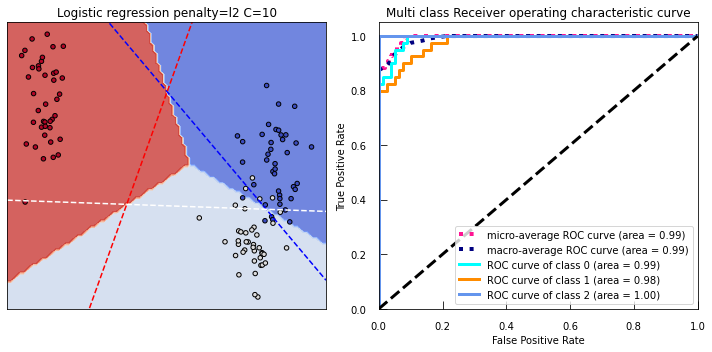

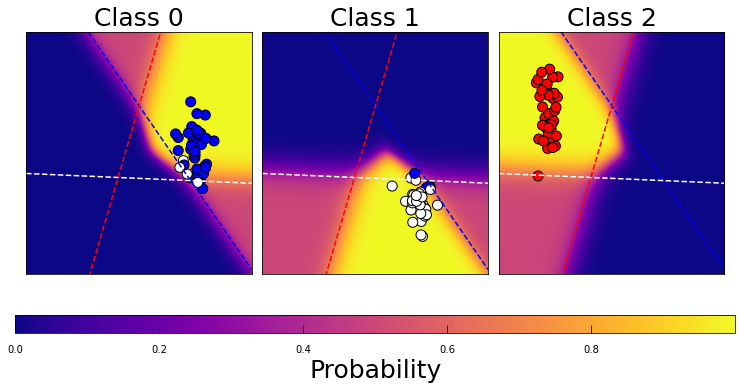

In [49]:
#one vs rest implementation
countour_lr('l2',X_3,y_3,10,'ovr')

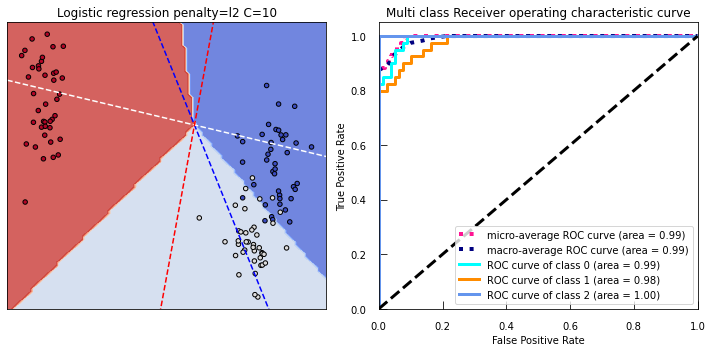

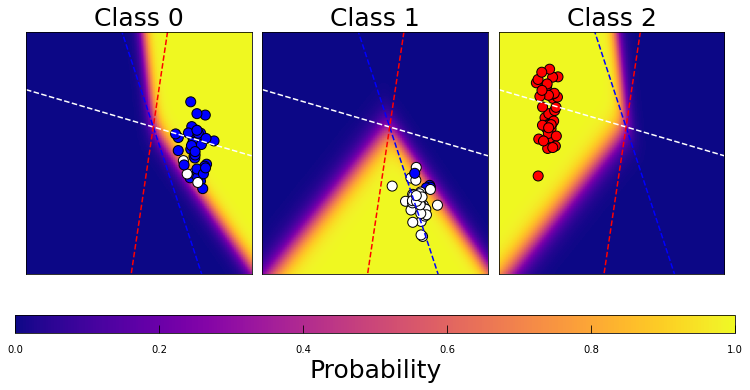

In [50]:
#Multinomial implementation** : the boundaries are less interpretable
countour_lr('l2',X_3,y_3,10,'multinomial')

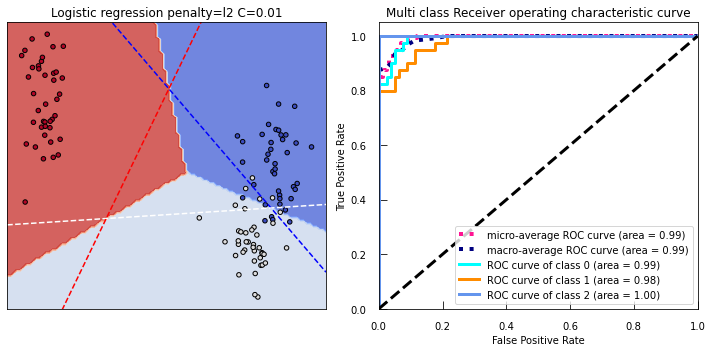

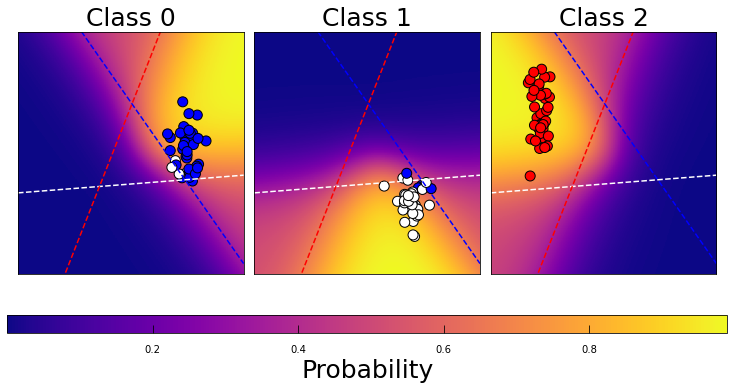

In [51]:
countour_lr('l2',X_3,y_3,10**-2,'ovr')

In the above I added quite a lot a l2 regularization, notice how the boundaries are fusier?

[Back to the ToC](#toc)

### LR on the penguin dataset <a class="anchor" id="LR-PENGUIN"></a>

Let's apply what we learned to the multiclass penguin dataset.

In [52]:
X_penguin_train, X_penguin_test, y_penguin_train, y_penguin_test = train_test_split(
                                                    X_penguin, y_penguin,
                                                    random_state=568132,stratify=y_penguin)

pipeline_lr=Pipeline([('scalar',StandardScaler()),
                     ('model',LogisticRegression(class_weight='balanced'))])

#hyper parameter space :
grid_values = {'model__C': np.logspace(-2,1,50),
               'model__penalty':['l1','l2'],
               'model__solver':['liblinear']}

# note the 'roc_auc_ovr' score!
grid_lr_auc_P = GridSearchCV(pipeline_lr, 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr',n_jobs=-1)

grid_lr_auc_P.fit(X_penguin_train, y_penguin_train)

testScore=grid_lr_auc_P.score(X_penguin_test,y_penguin_test)

print('Grid best parameter (max. accuracy):')
print( '\t' + '\n\t'.join([str(x) for x in grid_lr_auc_P.best_params_.items()]))
print('Grid best score (accuracy): ', grid_lr_auc_P.best_score_)
print('Grid best parameter (max. accuracy) model on test: ', testScore)

Grid best parameter (max. accuracy):
	('model__C', 0.02682695795279726)
	('model__penalty', 'l2')
	('model__solver', 'liblinear')
Grid best score (accuracy):  1.0
Grid best parameter (max. accuracy) model on test:  1.0


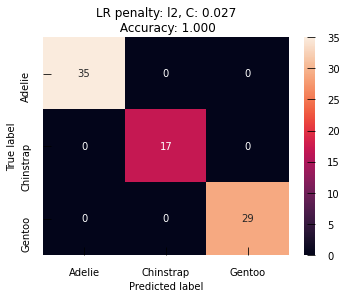

In [53]:
## predicting the labels on the test set    
y_pred_test=grid_lr_auc_P.predict(X_penguin_test)

bestP = grid_lr_auc_P.best_params_['model__penalty']
bestC = grid_lr_auc_P.best_params_['model__C']
testAcc = accuracy_score(y_penguin_test,y_pred_test)
    
plotTitle = 'LR penalty: {}, C: {:.3f}\n Accuracy: {:.3f}'.format( bestP,
                                                               bestC,
                                                               testAcc)

plotConfusionMatrix( y_penguin_test, y_pred_test, 
                    ['Adelie','Chinstrap','Gentoo'] , plotTitle , ax = None)

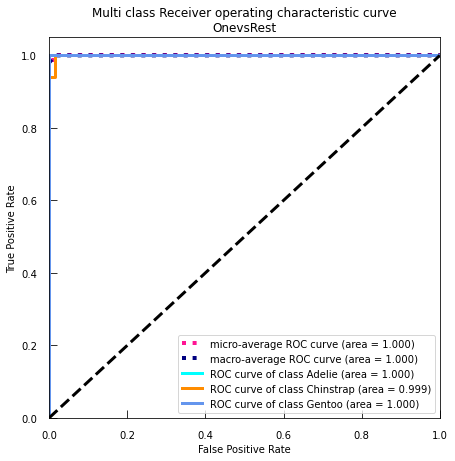

In [54]:
from utils import roc_multi_ovr

roc_multi_ovr(grid_lr_auc_P,3,
              X_penguin_train, 
              y_penguin_train,
              X_penguin_test, y_penguin_test)

In [55]:
grid_lr_auc_P.best_estimator_['model'].coef_


array([[-0.77443012,  0.43600148, -0.45619617, -0.27171993,  0.05196423,
        -0.28011247, -0.14624446,  0.33386188,  0.0587187 ,  0.19269369],
       [ 0.63171809,  0.13323326, -0.02891069, -0.19863282,  0.29272289,
         0.52888793,  0.45398492, -0.11981778, -0.071065  , -0.13222252],
       [ 0.29021617, -0.58648724,  0.53734309,  0.47673156, -0.35696955,
        -0.20676756, -0.2979934 , -0.20754126,  0.00481838, -0.08091325]])

In [56]:

## let's extract the model directly from the grid
lr = grid_lr_auc_P.best_estimator_['model']

# we get the weights of the fitted model, just for the class 0 : Adelie vs. rest
w=lr.coef_[0]

featureW = pd.DataFrame( {'feature': X_penguin.columns,
                        'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance for: Adelie prenguin vs. rest')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]


Features sorted per importance for: Adelie prenguin vs. rest


feature    weight
0     Culmen Length (mm) -0.774430
2    Flipper Length (mm) -0.456196
1      Culmen Depth (mm)  0.436001
7       Island_Torgersen  0.333862
5      Delta 13 C (o/oo) -0.280112
3          Body Mass (g) -0.271720
9               Sex_MALE  0.192694
6           Island_Dream -0.146244
8  Clutch Completion_Yes  0.058719
4      Delta 15 N (o/oo)  0.051964

**micro-exercise** : What do you think about these weights. Do all features belong in this model ?

[Back to the ToC](#toc)

# Support Vector Machine (SVM) <a class="anchor" id="SVM"></a>

The basic principle of SVM is pretty simple. SVM aims at finding the 'good' threshold (hyperplane) to separate data from different classes. Conceptually it is very different from logistic regression where you maximize the log likelihood of the log odds function. **With SVM you really look for an hyperplane that separates data and that's it : there is no underlying hypothesis about probability distribution or anything else. It is very geometrical.**

So what's a good threshold? Again it is going to depend on the metric you are interested in. But at least a good threshold should be linked to this biais variance trade off in the sens that it should offer flexibility to your model.

You can imagine that there is a quite a lot of hyperplanes separating data in your training set. You could stick your threshold right where the class 0 point closest to class 1 lies. But in that case it will be very far from the other class 0 points, which can be a problem. **You could decide that your threshold should be right between the two closest extreme of your classes but that is going to be very sensitive to missclassified data or extreme events... Those points choosen as a reference to put your threshold are called support vectors.** 



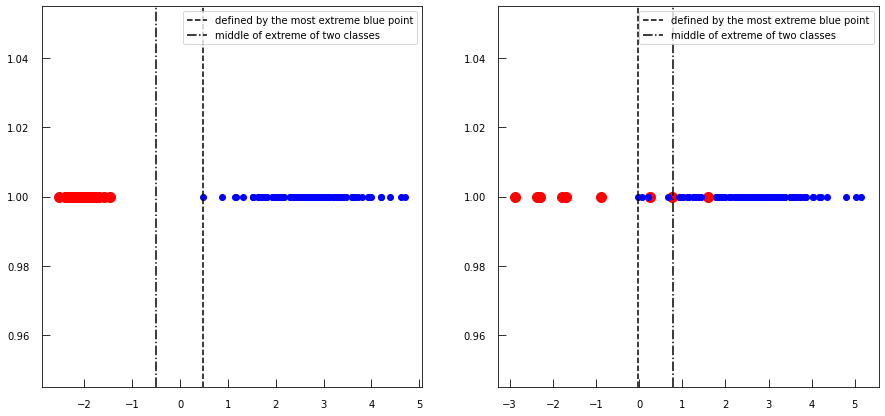

In [57]:
np.random.seed(10815657)


fig,ax = plt.subplots(1,2,figsize=(15,7))

# case 1 
norm1=0.2*np.random.randn(100)-2
norm2=0.8*np.random.randn(100)+2.5
ax[0].plot(norm1,[1]*100,'ro',markersize=10)
ax[0].plot(norm2,[1]*100,'bo')

min2 = min( norm2 )
max1 = max( norm1 )

ax[0].axvline(min2, color='k', linestyle='--', label='defined by the most extreme blue point')
ax[0].axvline( (min2+max1)/2,color='k',linestyle='-.',label='middle of extreme of two classes')
ax[0].legend(loc='best')


# case 2
cauch=0.8*np.random.standard_cauchy(10)-2
norm=1*np.random.randn(100)+2.5

ax[1].plot(cauch,[1]*10,'ro',markersize=10)
ax[1].plot(norm,[1]*100,'bo')

min2 = min( norm )
max1 = max( cauch )

ax[1].axvline(min2, color='k', linestyle='--', label='defined by the most extreme blue point')
ax[1].axvline( (min2+max1)/2,color='k',linestyle='-.',label='middle of extreme of two classes')
ax[1].legend(loc='best')


So, once again, you are confronted to a compromise. You should place your threshold somwhere that is globally best even though that would mean some miss-classification. We are back to our regularization problem and of course **Support vector machine has a regularization parameter : C**. The game now becomes placing your threshold right in the middle of points (support vectors) from  each classes that you have "chosen" to be general points for decision making : **they don't need to be the two closest points from different classes anymore. They need to be points where your hyperplane makes the least error differentiating classes.**

![svm_margin](../images/SVM_margin.png)

Image source : image by wikipedia user Larhmam, distributed under a [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/deed.en).

![3d_svm](../images/3d_svm.png)


You can see that there is a [dot product](https://en.wikipedia.org/wiki/Dot_product) involved : in the case of a linear hyperplane this dot product is just the cartesian dot product that you probably use all the time. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes. But you might be familiar with other scalar product : like for example when you proceed to a Fourier decomposition of a function. This particular scalar product acts on functions and so is not really of interest for us... But others exist.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non-linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\overrightarrow{x_{i}}.\overrightarrow{x_{j}}$ : cartesian

$(\overrightarrow{x_{i}}.\overrightarrow{x_{j}})^{d}$ : polynomial degree d

$exp(-\gamma||\overrightarrow{x_{i}}-\overrightarrow{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\overrightarrow{x_{i}}.\overrightarrow{x_{j}}+c)$ : hyperbolic tangent

**This is really powerful for classification but going non-linear by using a kernel trick prevents you from interpreting how your features are massaged to create this classifier... So, if you want interpretability and do science rather than engineering : keep it linear.**

Finally let's look at the analysis part of the problem : what is our loss function here ? (what do we want to optimize over? Remember for the logistic regression we were maximizing likelihood.)

You want to maximize the distance between your hyperplane and your support vectors. This distance is $\frac{2}{||\overrightarrow{w}||}$. So you want to minimize $||\overrightarrow{w}||$. 

So you want to minimize $||\overrightarrow{w}||$ with the constraint that most of the points on each side of the hyperplane belong to the same class. This translates into minimizing what is called a hinge loss :

$\frac{1}{m}\Sigma^{m}_{k=1}max(0,1-y_{k}(w^{T}x_{k}-b)) - \frac{1}{C}\Sigma^{n}_{i=1}||w_{i}||^{2}$

, where 
 * $y_k$ is $-1$ or $1$ depending on the class of the point $k$
 * the class of point $x_k$ is determined by the SVM using the sign of $(w^{T}x_{k}-b)$ (ie, on which side of the $(w^{T}x_{k}-b)=0$ hyperplane we are).


Note that you could also use a L1 regularization but it is not implemented in the function we are going to use.

Indeed if most of the data points are well separated in term of class on each side of the hyperplane then
 * most of the time $y_{k}(w^{T}x_{k}-b) \geq 1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)=0$ (that's good for minimizing our loss function), 
 * and a few times $y_{k}(w^{T}x_{k}-b) \leq -1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b) \geq 2$ (which is polluting our minimization of the loss function).

[Back to the ToC](#toc)

## Toy data : linear kernel <a class="anchor" id="SVM-linear"></a>

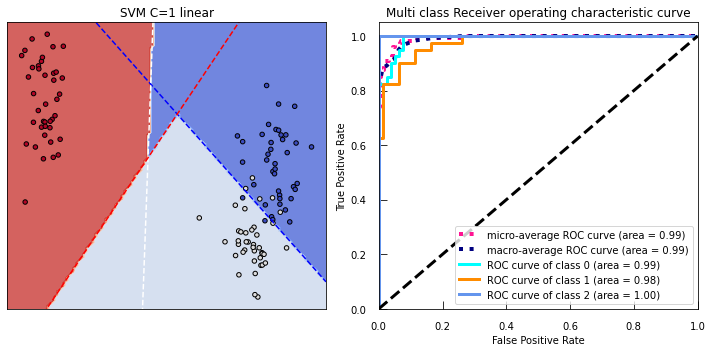

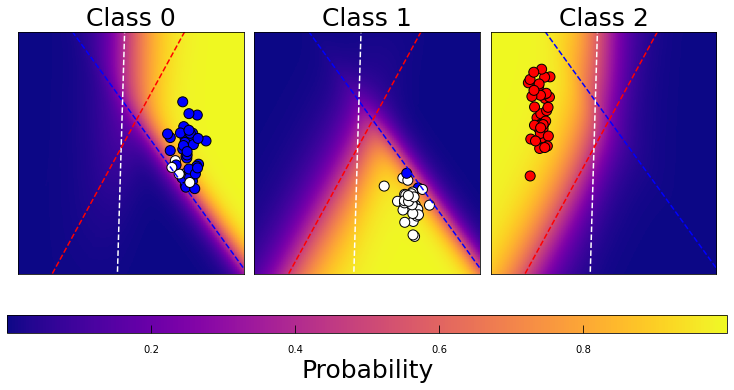

In [58]:
from utils import contour_SVM

#On multiple classes

contour_SVM(X_3,y_3,
            c=1,ker='linear')

#C=1 is the inverse of the weight on regularization, 
# linear is the type of kernel used,

The API offers us the possibility to have a probability for the decision function just like logistic regression (this is why I was able to plot those graphs). As I said before, this is not how the SVM works but it can be added after the learning to module decision. In particular the transformation used to get to the probability from the fit is a logistic function.... So it is a bit redundant and computationally demanding in my opinion... 

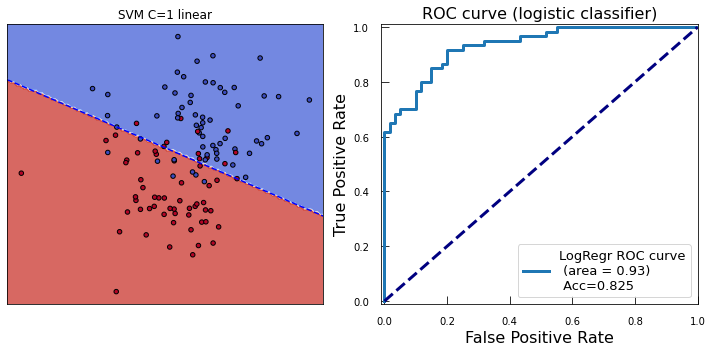

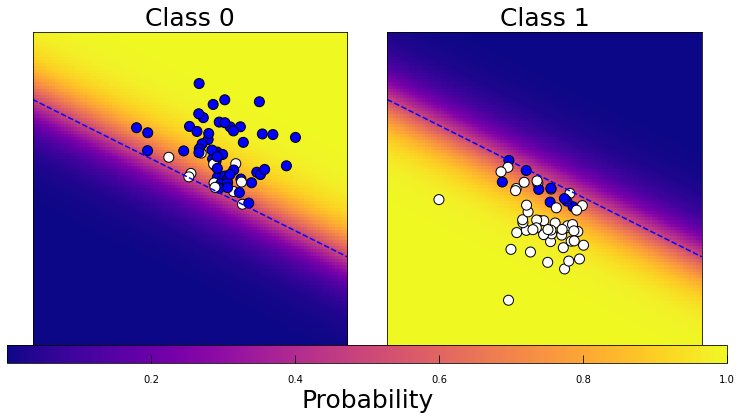

In [59]:
#only 2 classes
contour_SVM(X_toy_2,y_toy_2,c=1,ker='linear')

In the first panel the hyperplan is the plain line whereas the dashed lines are just here to guide your eyes toward the support vector chosen here: i.e. the points in the different classes chosen so the hyperplan sits right in between them. You can see that in this case the classifier allows some missclassification.

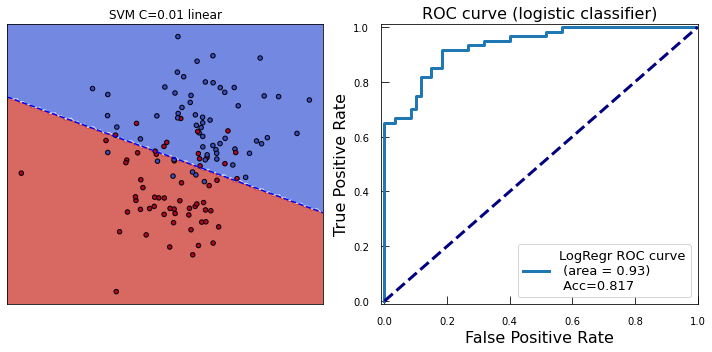

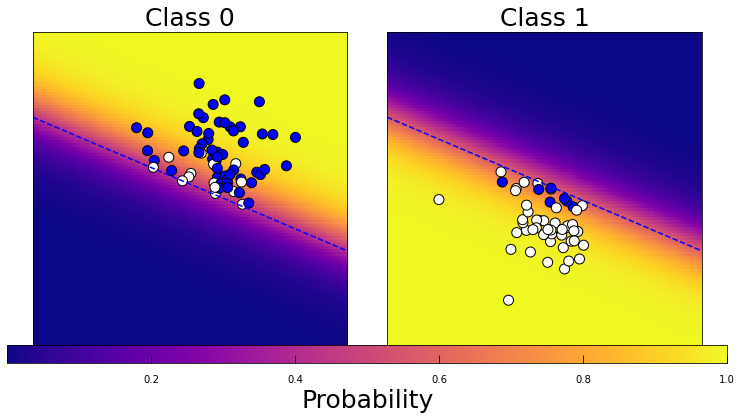

In [60]:
#let's put quite a lot of regularization
contour_SVM(X_toy_2,y_toy_2,c=0.01,ker='linear')

Reducing C to 0.01 increases regularization and so allows the classifier to be more flexible. This allows more mislabelling and so the support verctors represented by the dashed lines can be even further from each other and include more misslabelling in the training set.

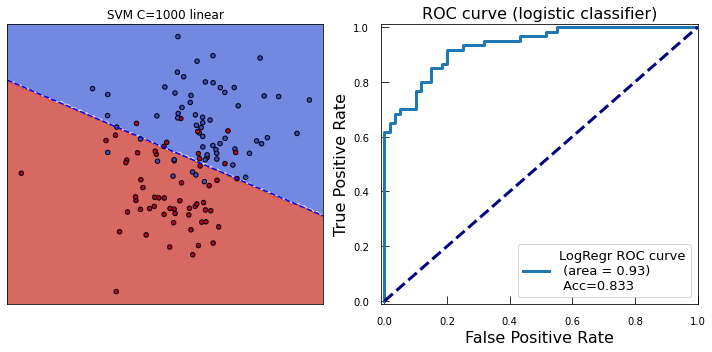

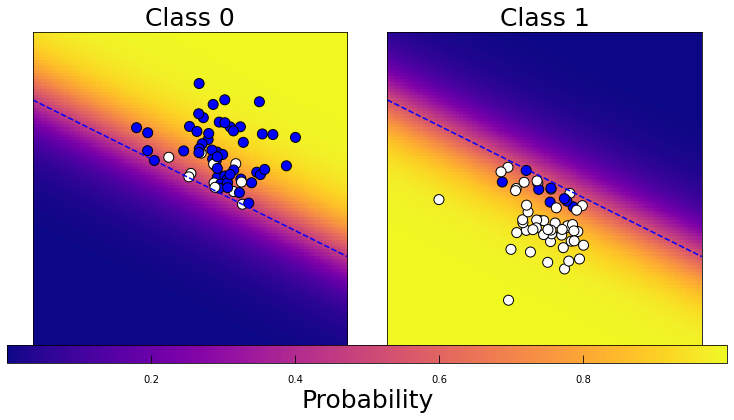

In [61]:
#let's put very little regularization
contour_SVM(X_toy_2,y_toy_2,c=1000,ker='linear')

The inverse is true. Reducing the regularization brings the support vectors closer to each other and reduce the number of misslabels on the training set.

[Back to the ToC](#toc)

## Toy data non linear kernel <a class="anchor" id="SVM-nonlinear"></a>

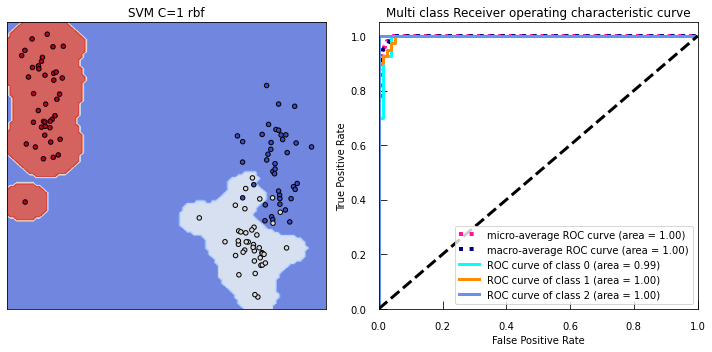

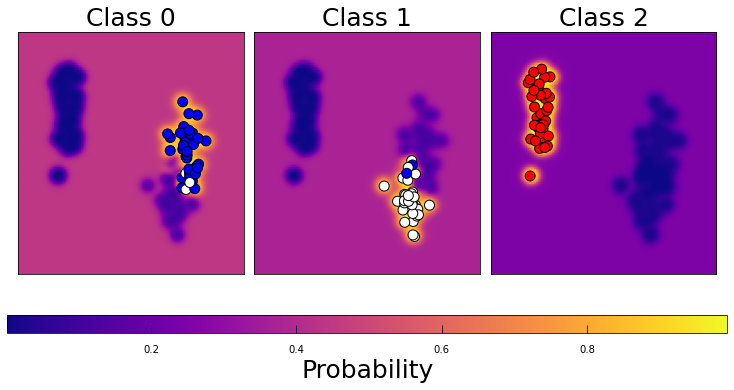

In [62]:
#let's change the scalar product and the notion of distance by using a rbf kernel
#Also we did'nt put much of regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=1)
# gam -> gamma -> standard deviation for the Gaussian Radial Basis function

In the above example we changed the kernel from linear to Gaussian radial basis. See how the classification boundaries are different from the linear model?

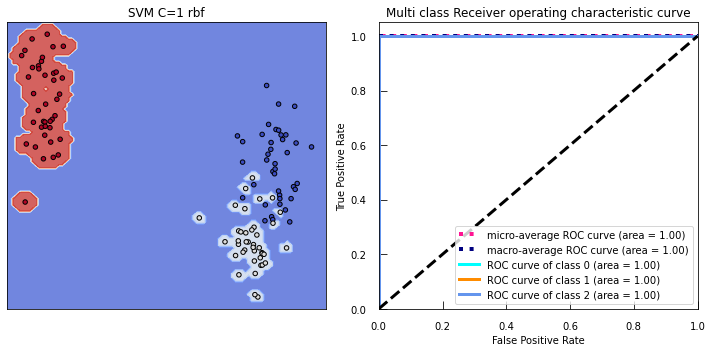

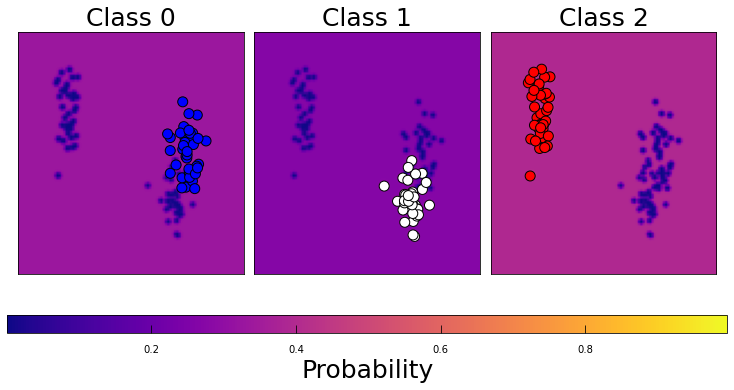

In [63]:
#even less regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=10)

In the above example we greatly reduce the standard deviation on the gaussian model (we increased $\gamma$). See how now the boundaries are really concentrated around each point? This $\gamma$ parameter can be linked to the number of neighbors in the KNN

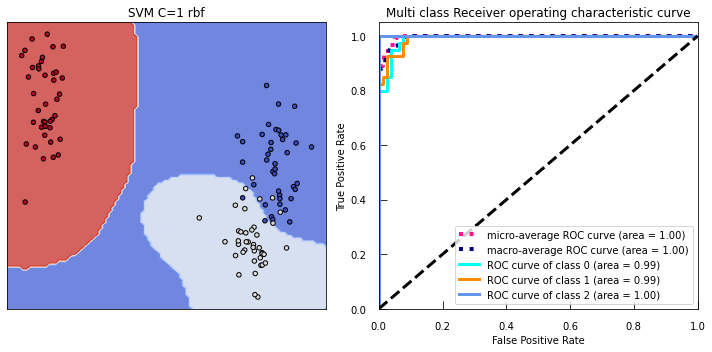

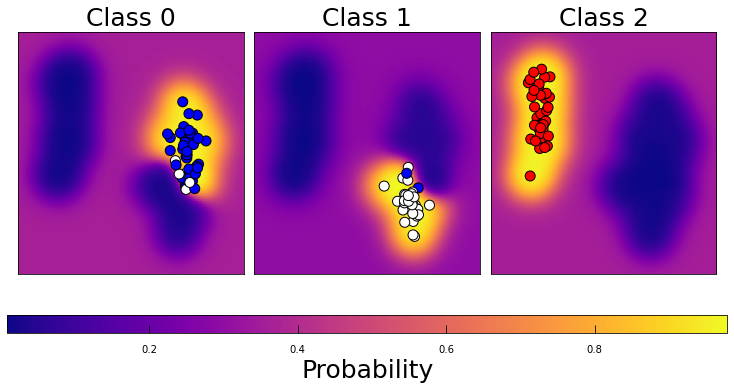

In [64]:
#more regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=0.1)

Inversely by expanding the variance in the gaussian we end up with larger chunks.

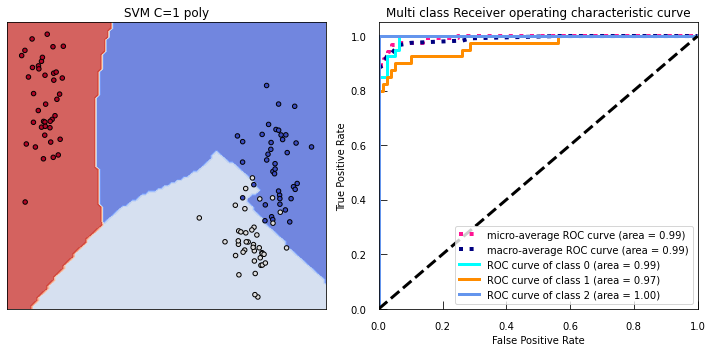

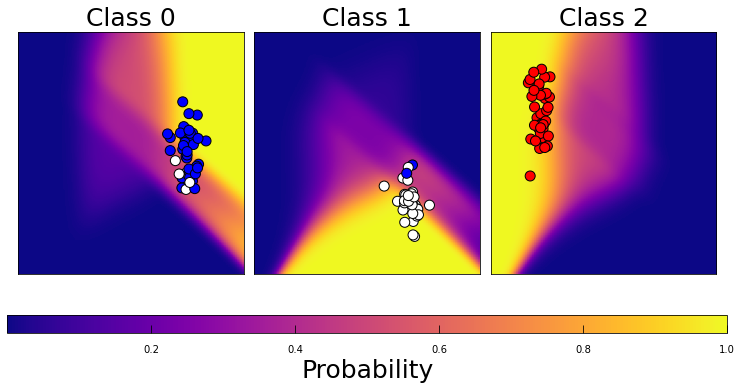

In [65]:
#little regularization but a polynomial kernel of degree 3 this time
contour_SVM(X_3,y_3,c=1,ker='poly',deg=3)

Finally, above we tried a degree 3 polynomial kernel?

[Back to the ToC](#toc)

## Cancer dataset <a class="anchor" id="SVM-hyperparameters"></a>

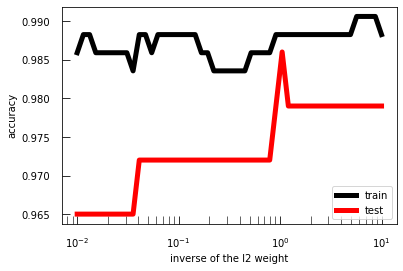

In [66]:
C_range=np.logspace(-2,1,50)


scores_test=[]
scores_train=[]

for c in C_range: 
    SVM_r = svm.SVC(C=c, kernel='linear', degree=1, gamma= 1,class_weight='balanced')
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('inverse of the l2 weight')
plt.ylabel('accuracy')
plt.plot(C_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(C_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

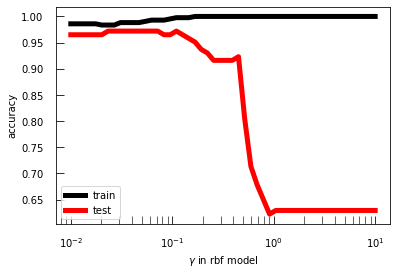

In [67]:

Gamma_range=np.logspace(-2,1,50)


scores_test=[]
scores_train=[]

for g in Gamma_range: 
    SVM_r = svm.SVC(C=1, kernel='rbf', degree=1, gamma= g,class_weight='balanced')
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('$\gamma$ in rbf model')
plt.ylabel('accuracy')
plt.plot(Gamma_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(Gamma_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

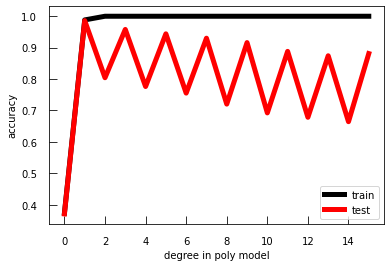

CPU times: user 253 ms, sys: 7.98 ms, total: 261 ms
Wall time: 260 ms


In [74]:
%%time
degree_range=np.arange(0,16,1)


scores_test=[]
scores_train=[]

for d in degree_range: 
    #print('testing degree',d)
    SVM_r = svm.SVC(C=1, kernel='poly', degree=d, gamma= 1,class_weight='balanced')
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('degree in poly model')
plt.ylabel('accuracy')
plt.plot(degree_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(degree_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
#plt.xscale('log')
plt.legend(loc='best')
plt.show()

Those 3 hyperparameters show the usual overfitting behavior when they are increased : monotonous increase of the accuracy on the train function whereas there is a maximum accuracy for the test function after which accuracy decreases with increasing hyperpaprameter value.

If you want to get the weights from the SVM just use `coef_` again but it will only work if you are in the context of a linear SVC.

[Back to the ToC](#toc)

# Exercise <a class="anchor" id="exo"></a>


Using either the **cancer or the penguin dataset** compare and find the 'best' classifier. What do you learn from those classifiers? 

Don't forget that you have also seen stuff about preprocessing.

Don't go too crazy as it can be time consuming: limit the number of parameter values you are testing for.

**Hint :** before, your grid_param was a dictionnary, and it was specific to a particular model since parameters are model dependant. 
To adapt to multiple models, make a list of `grid_params` where each instance of the list is a dictionnary of parameters specific to the model, you want to try.
*Example:*
``` python
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 }]
```

**Additionnal question** : How would you work with your PCA data and incorporate it to your model?

*Hint:* 
 * Don't forget that PCA needs a centering and a scaling step...
 * Adding PCA can be quite time consuming too. Try a small number of pca components first with other hyperparameters centered around what you found before!


Using iris dataset compare and find the 'best' classifier. What do you learn from those classifiers? Don't forget that you have also seen stuff about preprocessing.





In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## PENGUIN CORRECTION - NEEDS REVIEW

In [77]:
%%time
pipe = Pipeline([('scalar',StandardScaler()),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"classifier": [KNeighborsClassifier(n_jobs=-1)],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 "classifier__weights": ['uniform','distance']
                 },
                {"classifier": [LogisticRegression(n_jobs=-1)],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(-2, 2, 10)
                 },
                {"classifier": [svm.SVC()],
                 "classifier__kernel": ['linear', 'rbf', 'poly'],
                 "classifier__C":np.logspace(-2, 2, 10),
                 "classifier__degree":np.arange(0,10,1),
                 "classifier__gamma": np.logspace(-2,1,10)}]

gridsearch_P = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1,scoring='accuracy') # Fit grid search
best_model_P = gridsearch_P.fit(X_penguin_train,y_penguin_train)

print(best_model_P.best_params_)
print("Model accuracy:",best_model_P.score(X_penguin_test,y_penguin_test))

{'classifier': LogisticRegression(C=4.6415888336127775, n_jobs=-1), 'classifier__C': 4.6415888336127775, 'classifier__penalty': 'l2'}
Model accuracy: 1.0
CPU times: user 10.5 s, sys: 296 ms, total: 10.8 s
Wall time: 30.8 s


/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9835034  0.9835034  0.98358844 ... 0.99166667 0.54719388 0.98341837]
  warnings.warn(


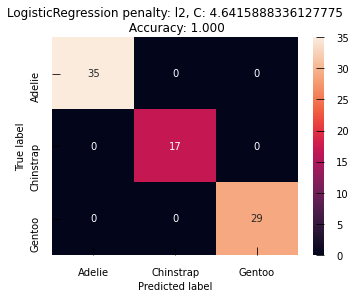

In [82]:
##the best model here is a Logistic Regression

## predicting the labels on the test set    
y_pred_test_c=best_model_P.predict(X_penguin_test)

bestC = best_model_P.best_params_['classifier__C']
bestPenalty = best_model_P.best_params_['classifier__penalty']

plotTitle = 'LogisticRegression penalty: {}, C: {}\n Accuracy: {:.3f}'.format(bestPenalty,
                                                                         bestC,
                                                                         accuracy_score(y_penguin_test,y_pred_test_c) )


plotConfusionMatrix( y_penguin_test, y_pred_test_c, 
                    ['Adelie','Chinstrap','Gentoo'] , plotTitle , 
                    ax = None)

## CANCER CORRECTION - NEEDS REVIEW

In [88]:
%%time
pipe = Pipeline([('scalar',StandardScaler()),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"classifier": [KNeighborsClassifier(n_jobs=-1)],
                 "classifier__n_neighbors": np.arange(1,30,5),
                 "classifier__weights": ['uniform','distance']
                 },
                {"classifier": [LogisticRegression(n_jobs=-1)],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(-2, 2, 10)
                 },
                {"classifier": [svm.SVC()],
                 "classifier__kernel": ['linear', 'rbf', 'poly'],
                 "classifier__C":np.logspace(-2, 2, 10),
                 "classifier__degree":np.arange(0,10,1),
                 "classifier__gamma": np.logspace(-2,1,10)}]

gridsearch_C = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1,scoring='roc_auc') # Fit grid search
best_model_C = gridsearch_C.fit(X_cancer_train,y_cancer_train)

print(best_model_C.best_params_)
print("Model accuracy:",best_model_C.score(X_cancer_test,y_cancer_test))

{'classifier': SVC(C=0.5994842503189409, gamma=0.046415888336127774, kernel='poly'), 'classifier__C': 0.5994842503189409, 'classifier__degree': 3, 'classifier__gamma': 0.046415888336127774, 'classifier__kernel': 'poly'}
Model accuracy: 0.9823899371069182
CPU times: user 8.05 s, sys: 195 ms, total: 8.24 s
Wall time: 26.2 s


/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95376048 0.95376048 0.99281675 ... 0.98739645 0.7812693  0.96657382]
  warnings.warn(


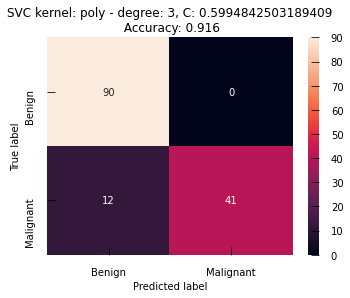

In [91]:
##the best model here is a SVC

## predicting the labels on the test set    
y_pred_test_c=best_model_C.predict(X_cancer_test)

bestC = best_model_C.best_params_['classifier__C']
bestKernel = best_model_C.best_params_['classifier__kernel']
bestDeg = best_model_C.best_params_['classifier__degree']

plotTitle = 'SVC kernel: {} - degree: {}, C: {}\n Accuracy: {:.3f}'.format(bestKernel,
                                                                           bestDeg,
                                                                         bestC,
                                                                         accuracy_score(y_cancer_test,y_pred_test_c) )


plotConfusionMatrix( y_cancer_test, y_pred_test_c, 
                    ['Benign','Malignant'] , plotTitle , 
                    ax = None)

In [99]:
%%time

from sklearn.decomposition import PCA

grid_param = {"classifier__kernel": ['poly'],
                 "classifier__C":np.logspace(-2, 2, 5),
                 "classifier__degree":np.arange(0,10,1)}



PCA_NCOMPONENTS = 4

pipe_pca = Pipeline([('scalar1',StandardScaler()),
                     ('pca',PCA(n_components=PCA_NCOMPONENTS)),
                     ("classifier", svm.SVC())])
# Create dictionary with candidate learning algorithms and their hyperparameters

# create a gridsearch of the pipeline, the fit the best model
gridsearch_c_pca = GridSearchCV(pipe_pca, 
                                grid_param, scoring='roc_auc',
                                cv=5, verbose=0,n_jobs=-1) # Fit grid search

best_model_c_pca = gridsearch_c_pca.fit(X_cancer_train,y_cancer_train)

print(best_model_c_pca.best_params_)
print("Model accuracy:",best_model_c_pca.score(X_cancer_test,y_cancer_test))


{'classifier__C': 100.0, 'classifier__degree': 1, 'classifier__kernel': 'poly'}
Model accuracy: 0.9909853249475891
CPU times: user 210 ms, sys: 55.7 ms, total: 266 ms
Wall time: 598 ms


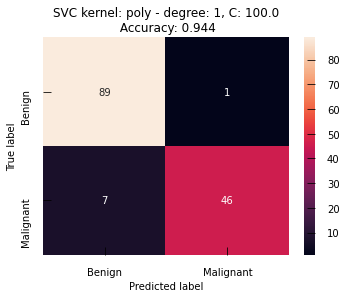

In [100]:

## predicting the labels on the test set    
y_pred_test_c=best_model_c_pca.predict(X_cancer_test)

bestC = best_model_c_pca.best_params_['classifier__C']
bestKernel = best_model_c_pca.best_params_['classifier__kernel']
bestDeg = best_model_c_pca.best_params_['classifier__degree']

plotTitle = 'SVC kernel: {} - degree: {}, C: {}\n Accuracy: {:.3f}'.format(bestKernel,
                                                                           bestDeg,
                                                                         bestC,
                                                                         accuracy_score(y_cancer_test,y_pred_test_c) )


plotConfusionMatrix( y_cancer_test, y_pred_test_c, 
                    ['Benign','Malignant'] , plotTitle , 
                    ax = None)

[Back to ToC](#toc)

# Appendix : Precision-Recall curves and alternative metrics <a id="PRcurve"></a>

If you would like to focus on your ability to detect class 1 rather than 0 use the precision recal curve :

Precision : $\frac{\bf{TP}}{\bf{TP}+\bf{FP}}$

Recall : $\frac{\bf{TP}}{\bf{TP}+\bf{FN}}$

You will see how it looks in the following paragraphes, just remember that just like before this method estimate statistics (here precision and recall) over different decision threshold. You can summurize the goodness of the model with one number just like before : the average precision. We will see that later on 


If you don't feel like going through different scoring (i.e. accuracy), you can compare your model to a dummy classifier that will either only learn the statistic of your training set or always answer the most probable class (other dummy classifier are available): `sklearn.dummy.DummyClassifier`

In [ ]:
y_score_lr_c = lr.decision_function(X_cancer_test_scaled)
plot_precision_recall_curve(lr,X_cancer_test_scaled, y_cancer_test)

Other interesting diagnostic plots and metric exist. Instead of looking at the ROC curve you could look at the **precision recall curve**. Another very important metric for imbalanced datset is the **f-measure**. 

![metric](../images/metric.png)

In [ ]:
#Precision recall curve : AP = Average Precision
y_score_lr_c = lr.decision_function(X_cancer_test_scaled)
plot_precision_recall_curve(lr,X_cancer_test_scaled, y_cancer_test)

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

where $R_n$ is recall at threshold n and $P_n$ is precision at threshold n

So AP (Avergae precision) is the weighted average over all the threshold of the precision relative to the difference of recall between two thresholds

In [ ]:
# Those are the other scores (other than accuracy and roc_auc) to evaluate the performence of your model.
#If you recall we used scoring=accuracy in our GridSearchCV. But we could use another metric.

from sklearn.metrics.scorer import SCORERS
for i in sorted(list(SCORERS.keys())):
    print(i)